In [1]:

# Access modules in the py folder
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# Get needed libraries
from FRVRS import fu, nu
import numpy as np
import os
import os.path as osp
from pandas import DataFrame, Series, concat, notnull
import pandas as pd
import re


# Explore OW Participants and Scenes

In [3]:

# The following data points were analyzed for each participant for each scene
if nu.pickle_exists('ow_participant_scenes_df'): participant_scenes_df = nu.load_object('ow_participant_scenes_df')
else:
    rows_list = []
    for (participant_id, encounter_layout, session_uuid, scene_id), scene_df in participants_df.groupby(
        ['participant_id', 'encounter_layout', 'session_uuid', 'scene_id']
    ):
        row_dict = {'participant_id': participant_id, 'encounter_layout': encounter_layout, 'session_uuid': session_uuid, 'scene_id': scene_id}
        
        # Total number of actions: Overall number of actions taken by the participant
        mask_series = scene_df.action_type.isin(fu.action_types_list)
        row_dict['scene_action_count'] = scene_df[mask_series].shape[0]
        
        # Count of assessment actions: Number of actions related to patient evaluation
        mask_series = scene_df.action_type.isin(['PATIENT_ENGAGED', 'PULSE_TAKEN'])
        row_dict['scene_assessment_count'] = scene_df[mask_series].shape[0]
        
        # Count of treatment actions: Number of actions related to patient treatment
        mask_series = scene_df.action_type.isin(['INJURY_TREATED'])
        row_dict['scene_treatment_count'] = scene_df[mask_series].shape[0]
        
        # Count of tags applied: Number of tag application events (e.g., yellow, green)
        mask_series = scene_df.action_type.isin(['TAG_APPLIED'])
        row_dict['scene_tag_application_count'] = scene_df[mask_series].shape[0]
        
        # Treat expectant patient (yes/no): Binary variable indicating taking time to treat patients expected to die anyway
        treated_expectant = False
        mask_series = scene_df.patient_salt.isin(['EXPECTANT']) & ~scene_df.patient_id.isnull()
        if mask_series.any():
            patient_ids_list = scene_df[mask_series].patient_id.unique().tolist()
            for patient_id in patient_ids_list:
                mask_series = (scene_df.patient_id == patient_id)
                patient_df = scene_df[mask_series]
                mask_series = ~patient_df.injury_treated_required_procedure.isnull() | ~patient_df.tool_applied_type.isnull()
                if mask_series.any(): treated_expectant = True
        row_dict['treated_expectant'] = treated_expectant
        
        # Triage efficiency: Number of swaps it takes to get the sequence (in which patients were interacted with) to the ideal
        actual_sequence, ideal_sequence, sort_dict = fu.get_actual_and_ideal_patient_sort_sequences(scene_df)
        unsort_dict = {v1: k for k, v in sort_dict.items() for v1 in v}
        swaps_to_perfect_order_count = nu.count_swaps_to_perfect_order([unsort_dict[i] for i in ideal_sequence], [unsort_dict[a] for a in actual_sequence])
        row_dict['swaps_to_perfect_order_count'] = swaps_to_perfect_order_count
        
        # Time to hemorrhage control: Time taken to control bleeding for an entire simulated scene
        scene_start = fu.get_scene_start(scene_df)
        row_dict['scene_start'] = scene_start
        controlled_time = fu.get_time_to_last_hemorrhage_controlled(scene_df)
        row_dict['time_to_hemorrhage_control'] = controlled_time
    
        rows_list.append(row_dict)
    
    participant_scenes_df = DataFrame(rows_list)
    nu.store_objects(ow_participant_scenes_df=participant_scenes_df)
    nu.save_data_frames(ow_participant_scenes_df=participant_scenes_df)

In [4]:

if nu.pickle_exists('ow_participants_df'): participants_df = nu.load_object('ow_participants_df')
else:
    
    # load data frames
    data_frames_dict = nu.load_data_frames(
        metrics_evaluation_open_world_df='', metrics_evaluation_open_world_json_stats_df='', metrics_evaluation_open_world_scene_stats_df=''
    )
    logs_df = data_frames_dict['metrics_evaluation_open_world_df']
    json_stats_df = data_frames_dict['metrics_evaluation_open_world_json_stats_df']
    scene_stats_df = data_frames_dict['metrics_evaluation_open_world_scene_stats_df']

    participants_df = DataFrame([])
    for participant_id in range(2_024_201, 2_024_223+1):
        ldf = logs_df[logs_df.participant_id == participant_id]
        fsdf = json_stats_df[json_stats_df.participant_id == participant_id]
        ssdf = scene_stats_df[scene_stats_df.participant_id == participant_id]
        on_columns = sorted(set(ldf.columns).intersection(set(fsdf.columns)))
        participant_elevens_df = ldf.merge(fsdf, on=on_columns)
        on_columns = sorted(set(participant_elevens_df.columns).intersection(set(ssdf.columns)))
        participant_elevens_df = participant_elevens_df.merge(ssdf, on=on_columns)
        if participant_elevens_df.shape[0]: participants_df = concat([participants_df, participant_elevens_df], axis='index')
    nu.store_objects(ow_participants_df=participants_df)
    nu.save_data_frames(ow_participants_df=participants_df)


## Box Plots

In [5]:

desert_patients_list = ['Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root']
jungle_patients_list = ['Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root']
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']


### Get column and value descriptions

In [6]:

# Attempt to manufacture some better column names
from pandas import read_excel

file_path = '../data/xlsx/Metrics_Evaluation_Dataset_organization_for_BBAI.xlsx'
dataset_organization_df = read_excel(file_path)

mask_series = ~dataset_organization_df.Description.isnull()#re.sub('[^A-Za-z0-9]+', '_', x)
df = dataset_organization_df[mask_series]
description_dict = df.set_index('Variable').Description.to_dict()
new_description_dict = description_dict.copy()
for k, v in description_dict.items():
    new_description_dict[k] = v
    new_description_dict[f'{k}_Text'] = v
description_dict = new_description_dict.copy()

In [7]:

# Fix the doubled up descriptions
mask_series = dataset_organization_df.Labels.map(lambda x: ';' in str(x))
for row_index, label in dataset_organization_df[mask_series].Labels.items():
    labels_list = re.split(' *; *', str(label), 0)
    dataset_organization_df.loc[row_index, 'Labels'] = labels_list[0]
    
    # Get a copy of the row
    new_row = dataset_organization_df.loc[row_index].copy()
    
    # Modify the desired column value
    new_row['Labels'] = labels_list[1]
    
    # Append the new row to the DataFrame
    dataset_organization_df = dataset_organization_df.append(new_row, ignore_index=True)

In [8]:

# Get a copy of the row
mask_series = (dataset_organization_df.Variable == 'AD_Del_Omni')
new_row = dataset_organization_df.loc[mask_series].copy()

# Modify the desired column value
new_row['Variable'] = 'AD_Del_Omni_Text'

# Append the new row to the DataFrame
dataset_organization_df = dataset_organization_df.append(new_row, ignore_index=True)

In [9]:

mask_series = dataset_organization_df.Labels.map(lambda x: '=' in str(x))
value_descriptions_columns = dataset_organization_df[mask_series].Variable.unique().tolist()
def get_value_description(column_name, column_value):
    value_description = ''
    if not pd.isna(column_value):
        mask_series = (dataset_organization_df.Variable == column_name) & ~dataset_organization_df.Labels.isnull()
        if mask_series.any():
            df = dataset_organization_df[mask_series]
            mask_series = df.Labels.map(lambda label: re.split(' *= *', str(label), 0)[0] == str(int(float(column_value))))
            if mask_series.any():
                label = df[mask_series].Labels.squeeze()
                value_description = re.split(' *= *', str(label), 0)[1]
    
    return value_description
column_name = 'MedRole'
column_value = np.nan
get_value_description(column_name, column_value)

''


### Participants Dataset

In [10]:

# Add a value descriptions column
if 'medical_role' not in participants_df.columns:
    participants_df['medical_role'] = participants_df.MedRole.map(lambda cv: get_value_description('MedRole', cv)).replace('', np.nan)
    nu.store_objects(ow_participants_df=participants_df)
    nu.save_data_frames(ow_participants_df=participants_df)

if 'medical_role' in participants_df.columns:
    display(participants_df.medical_role.unique())

array(['Paramedic', 'Other', 'Medical student', 'EM resident', nan,
       'EM faculty'], dtype=object)


#### Examine inventory and numeric columns

In [11]:

# inventory_regex = re.compile('configData(?:_narrative_narrativeSections\d+)?_availableInventory_([a-z]+)([A-Z][a-z]+)?Count')
inventory_regex = re.compile('configData_availableInventory_([a-z]+)([A-Z][a-z]+)?Count')
columns_list = [cn for cn in participants_df.columns if inventory_regex.fullmatch(cn)]
availableInventory_df = participants_df[columns_list].drop_duplicates().reset_index(drop=True)
print(availableInventory_df.shape)
def get_inventory_from_column_name(cn):
    parts_list = inventory_regex.split(cn)
    first_word = parts_list[1].title()
    if len(first_word) == 2: first_word = first_word.upper()
    second_word = parts_list[2]
    if second_word is not None: inventory_str = ' '.join([first_word, second_word])
    else: inventory_str = first_word
    
    return inventory_str

(4, 10)


In [45]:

numeric_columns = [
    'actual_engagement_distance', 'distracted_engagement_distance', 'first_engagement', 'first_treatment',
    'ideal_engagement_distance', 'injury_correctly_treated_count', 'injury_not_treated_count', 'injury_treatments_count',
    'injury_wrongly_treated_count', 'last_engagement', 'last_still_engagement', 'patient_count', 'pulse_taken_count',
    'teleport_count', 'time_to_hemorrhage_control_per_patient', 'time_to_last_hemorrhage_controlled', 'total_actions', 'triage_time',
    'voice_capture_count', 'walk_command_count', 'wave_command_count'
]
nu.store_objects(participants_df_numeric_columns=numeric_columns)

Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/participants_df_numeric_columns.pkl


In [12]:

# Get the participants data frame numeric columns
if nu.pickle_exists('participants_df_numeric_columns'): numeric_columns = nu.load_object('participants_df_numeric_columns')
else:
    numeric_columns = nu.get_numeric_columns(participants_df.sample(500))
    nu.store_objects(participants_df_numeric_columns=numeric_columns)

In [13]:

if 'available_inventory_group' not in participants_df.columns:
    for row_index, row_series in availableInventory_df.iterrows():
        mask_series = True
        for cn, cv in row_series.iteritems():
            mask_series &= (participants_df[cn] == cv)
        participants_df.loc[mask_series, 'available_inventory_group'] = row_index
    nu.store_objects(ow_participants_df=participants_df)
    nu.save_data_frames(ow_participants_df=participants_df)

In [41]:

# Find a column highly correlated to your available inventory group
base_mask_series = participants_df.patient_id.isin(desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list)
cn = 'available_inventory_group'
mask_series = base_mask_series & ~participants_df[cn].isnull()
transformable_df = participants_df[mask_series].groupby(fu.scene_groupby_columns).mean().reset_index(drop=False).sort_values(cn)
df = transformable_df.corr().dropna(axis='index', how='all')[cn].sort_values().reset_index(drop=False).rename(columns={'index': 'column_name'})
mask_series = df.column_name.map(lambda x: not x.startswith('configData_'))
df[mask_series].dropna(axis='index', how='any')

,column_name,available_inventory_group
103,patient_count,-0.730810
106,ideal_engagement_distance,-0.670614
107,distracted_engagement_distance,-0.648320
109,combo_turbulence,-0.622696
110,actual_engagement_distance,-0.591781
...,...,...
279,injury_correctly_treated_count,0.358939
282,injury_treatments_count,0.410359
292,actual_ideal_delta,0.624835
353,YrsMilExp,0.909611


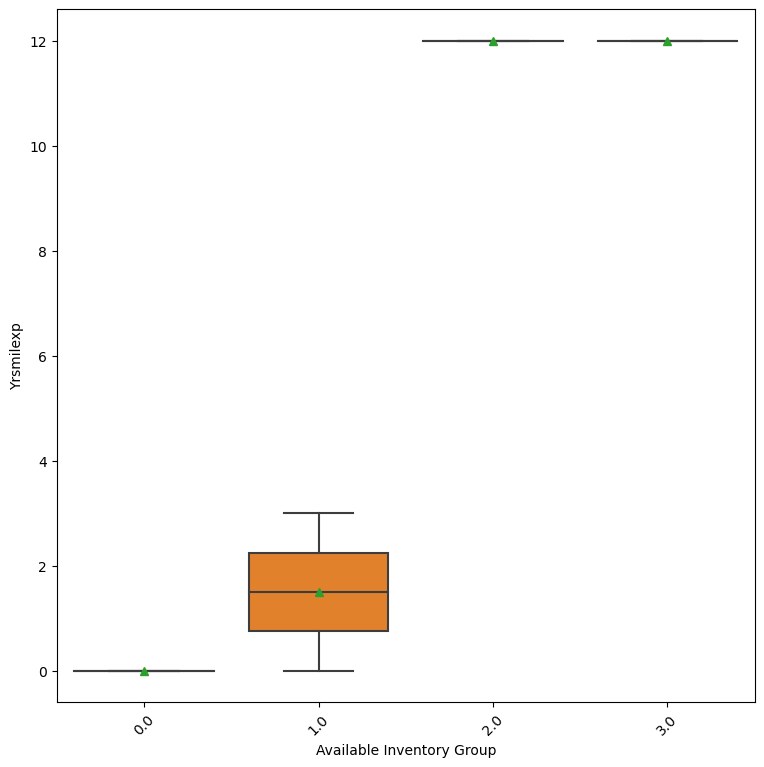

In [43]:

cn = 'YrsMilExp'
mask_series = base_mask_series & ~participants_df[cn].isnull()
if mask_series.any():
    transformable_df = participants_df[mask_series].groupby(fu.scene_groupby_columns).min().reset_index(drop=False).sort_values(cn)
    fu.plot_grouped_box_and_whiskers(
        transformable_df,
        'available_inventory_group',
        cn,
        'Available Inventory Group',
        ' '.join([w.title() for w in cn.split('_')]),
        transformer_name=None,
        is_y_temporal=False,
    )

wave_command_count: 20 more to go


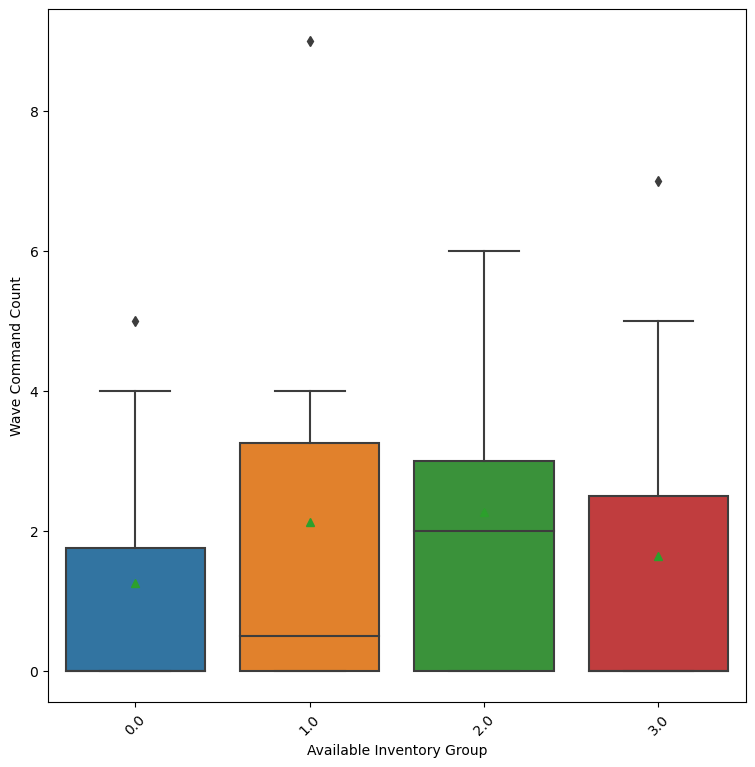

wave_command_count: 20 more to go


In [46]:

while True:
    cn = numeric_columns.pop()
    mask_series = base_mask_series & ~participants_df[cn].isnull()
    if mask_series.any():
        transformable_df = participants_df[mask_series].groupby(fu.scene_groupby_columns).min().reset_index(drop=False).sort_values(cn)
        if (len(transformable_df.groupby('available_inventory_group').groups.keys()) > 3):
            if (transformable_df.groupby('available_inventory_group')[cn].std().min() > 0.0):
                print(f'{cn}: {len(numeric_columns)} more to go')
                fu.plot_grouped_box_and_whiskers(
                    transformable_df,
                    'available_inventory_group',
                    cn,
                    'Available Inventory Group',
                    ' '.join([w.title() for w in cn.split('_')]),
                    transformer_name=None,
                    is_y_temporal=False,
                )
                nu.store_objects(participants_df_numeric_columns=numeric_columns, verbose=False)
                print(f'{cn}: {len(numeric_columns)} more to go')
                break

In [ ]:

# Examine medical role whisker plots
while True:
    cn = numeric_columns.pop()
    mask_series = participants_df.patient_id.isin(desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list)
    mask_series &= ~participants_df[cn].isnull()
    if mask_series.any():
        transformable_df = participants_df[mask_series].groupby(fu.scene_groupby_columns).min().reset_index(drop=False).sort_values(cn)
        if (len(transformable_df.groupby('medical_role').groups.keys()) > 3) and (transformable_df.groupby('medical_role')[cn].std().min() > 0.0):
            print(f'{cn}: {len(numeric_columns)} more to go')
            fu.plot_grouped_box_and_whiskers(
                transformable_df,
                'medical_role',
                cn,
                'Medical Role',
                ' '.join([w.title() for w in cn.split('_')]),
                transformer_name=None,
                is_y_temporal=False,
            )
            nu.store_objects(participants_df_numeric_columns=numeric_columns, verbose=False)
            print(f'{cn}: {len(numeric_columns)} more to go')
            break


----

In [ ]:

columns_list = [
    'total_assessment_count', 'total_tag_application_count', 'total_treatment_count', 'mean_first_patient_interaction', 'total_action_count',
    'max_time_to_hemorrhage_control', 'triage_time', 'time_to_last_hemorrhage_controlled', 'total_patient_engagement_count',
    'time_to_hemorrhage_control_per_patient', 'mean_percentage_tag_correct', 'mean_last_patient_interaction', 'MedExp', 'AD_KDMA_Sim', 'ST_ConfFC_Omni_Text',
    'ST_ConfFC_Text', 'AD_ConfFC_Text', 'AD_Del_Text', 'AD_ConfFC_Omni_Text', 'Trust', 'ST_KDMA_Sim', 'ST_AttribGrp_Text', 'AD_KDMA_Text', 'ST_Del_Text',
    'AD_AttribGrp_Sim', 'AD_AttribGrp_Text', 'PropTrust', 'ST_AttribGrp_Sim', 'YrsMilExp', 'AD_Del_Omni_Text', 'MilitaryExp', 'Delegation', 'ST_KDMA_Text',
    'MedRole', 'ST_Del_Omni_Text'
]

In [4]:

participant_columns = [
    'ST_Del_Text', 'AD_AttribGrp_Sim', 'Trust', 'ST_ConfFC_Text', 'Delegation', 'YrsMilExp', 'AD_Del_Text', 'MedExp', 'AD_AttribGrp_Text',
    'ST_ConfFC_Omni_Text', 'PropTrust', 'ST_KDMA_Text', 'AD_KDMA_Text', 'ST_AttribGrp_Text', 'ST_Del_Omni_Text', 'MilitaryExp', 'AD_ConfFC_Omni_Text',
    'MedRole', 'ST_AttribGrp_Sim', 'AD_ConfFC_Text', 'ST_KDMA_Sim', 'AD_Del_Omni_Text', 'AD_KDMA_Sim'
]
needed_columns = [
    'scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'configData_scene',
    'configData_scenarioData_name', 'configData_scenarioData_description', 'encounter_layout', 'Sim1', 'Sim2'
] + participant_columns

In [6]:

# Patients in our simulations are always given their same SORT designation
from IPython.display import HTML

mask_series = ~participants_df.patient_sort.isnull() & participants_df.patient_id.isin(
    desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list
)
columns_list = ['patient_id', 'patient_sort']
HTML(participants_df[mask_series][columns_list].drop_duplicates().sort_values(columns_list).reset_index(drop=True).to_html())

,patient_id,patient_sort
0,Civilian 1 Female Root,waver
1,Marine 1 Male Root,still
2,Marine 2 Male Root,waver
3,Marine 3 Male Root,waver
4,Marine 4 Male Root,waver
5,Navy Soldier 1 Male Root,still
6,Navy Soldier 2 Male Root,waver
7,Navy Soldier 3 Male Root,waver
8,Navy Soldier 4 Female Root,waver
9,Open World Civilian 1 Male Root,waver


In [23]:

# By analyzing the visualizations and exploring additional DVs, we can identify metrics with high variability across environments, fidelities, and performers
participant_scenes_df.var().sort_values()

treated_expectant               2.444444e-01
scene_id                        3.784512e-01
swaps_to_perfect_order_count    1.026128e+01
scene_tag_application_count     1.761818e+01
participant_id                  5.532458e+01
scene_treatment_count           1.053279e+02
scene_assessment_count          7.528539e+02
scene_action_count              1.936488e+06
time_to_hemorrhage_control      2.078133e+11
scene_start                     2.206917e+11
dtype: float64

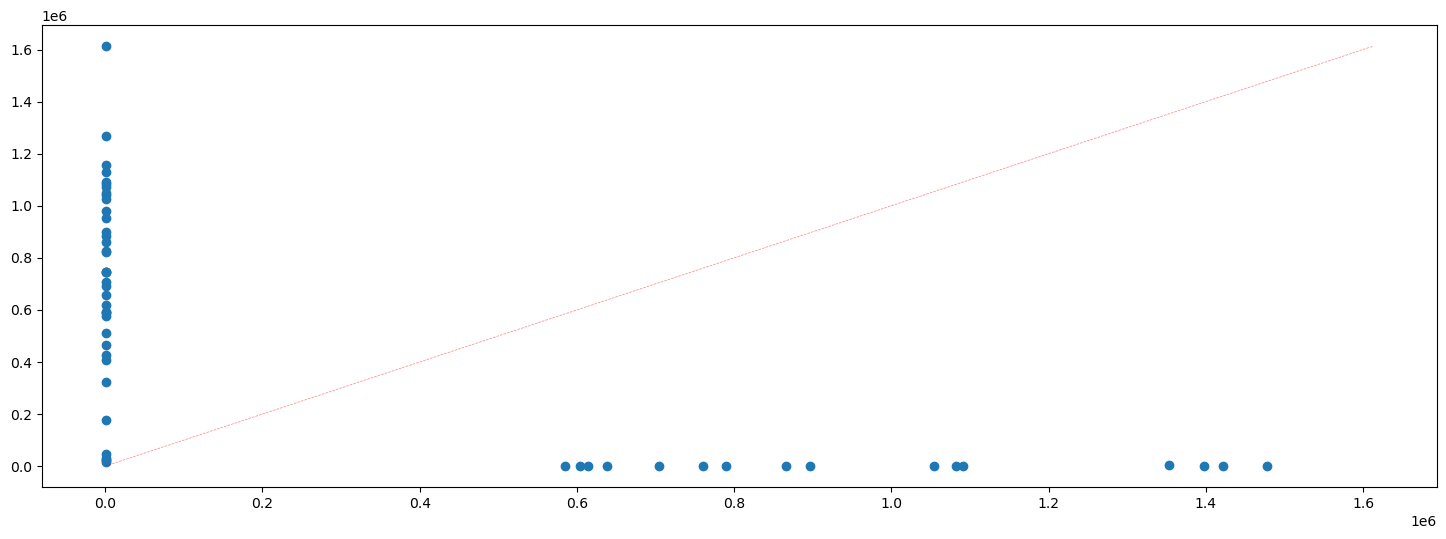

In [27]:

# Plot time to hemorrhage control vs scene start
x_srs = participant_scenes_df.scene_start
y_srs = participant_scenes_df.time_to_hemorrhage_control

fig, ax = plt.subplots(figsize=(18, 6))
path_collection_obj = ax.scatter(x_srs, y_srs, alpha=1.0)

# Calculate the limits for the diagonal line
max_x = max_y = max(max(x_srs), max(y_srs))
min_x = min_y = min(min(x_srs), min(y_srs))

# Draw diagonal line
line2d_objs_list = ax.plot([min_x, max_x], [min_y, max_y], linewidth=.5, color='red', linestyle='--', alpha=.5)

['ST_KDMA_Text', 'ST_KDMA_Sim', 'ST_AttribGrp_Text', 'ST_AttribGrp_Sim', 'ST_Del_Text', 'ST_ConfFC_Text', 'ST_Del_Omni_Text', 'ST_ConfFC_Omni_Text']
['AD_KDMA_Text', 'AD_KDMA_Sim', 'AD_AttribGrp_Text', 'AD_AttribGrp_Sim', 'AD_Del_Text', 'AD_ConfFC_Text', 'AD_Del_Omni_Text', 'AD_ConfFC_Omni_Text']


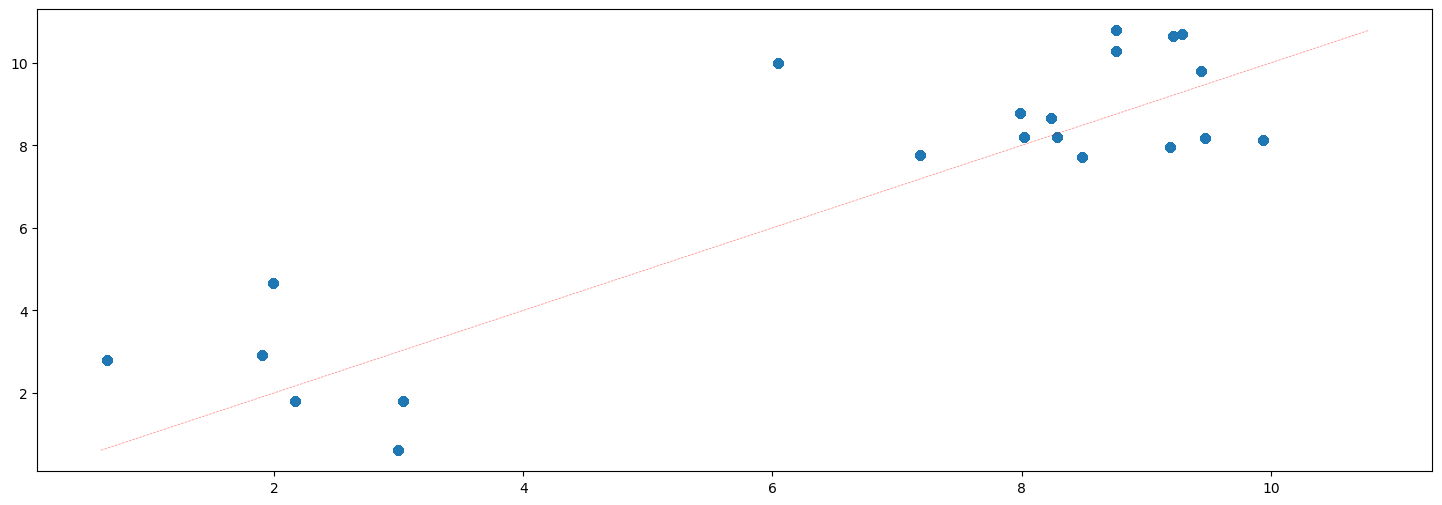

In [21]:

# Performer: Separate visualizations for participants using ADEPT (AD) and SOARTECH (ST) platforms
import matplotlib.pyplot as plt

# print(sum([float(n) for n in '0.434775	0.348326	1.0	0.0	1.0	2.5	1.0	4.0'.split('	')]))
columns_list = [cn for cn in participants_df.columns if cn.startswith('ST_')]
print(columns_list)
y_srs = participants_df[columns_list].T.sum()
# display(y_srs.value_counts())

# print(sum([float(n) for n in '0.416667	0.341667	0.0	0.0	0.5	2.5	1.0	4.0'.split('	')]))
columns_list = [cn for cn in participants_df.columns if cn.startswith('AD_')]
print(columns_list)
x_srs = participants_df[columns_list].T.sum()
# display(x_srs.value_counts())

fig, ax = plt.subplots(figsize=(18, 6))
path_collection_obj = ax.scatter(x_srs, y_srs, alpha=1.0)

# Calculate the limits for the diagonal line
max_x = max_y = max(max(x_srs), max(y_srs))
min_x = min_y = min(min(x_srs), min(y_srs))

# Draw diagonal line
line2d_objs_list = ax.plot([min_x, max_x], [min_y, max_y], linewidth=.5, color='red', linestyle='--', alpha=.5)

['ST_KDMA_Text', 'ST_AttribGrp_Text', 'AD_KDMA_Text', 'AD_AttribGrp_Text', 'ST_Del_Text', 'ST_ConfFC_Text', 'ST_Del_Omni_Text', 'ST_ConfFC_Omni_Text', 'AD_Del_Text', 'AD_ConfFC_Text', 'AD_Del_Omni_Text', 'AD_ConfFC_Omni_Text']
['ST_KDMA_Sim', 'ST_AttribGrp_Sim', 'AD_KDMA_Sim', 'AD_AttribGrp_Sim']


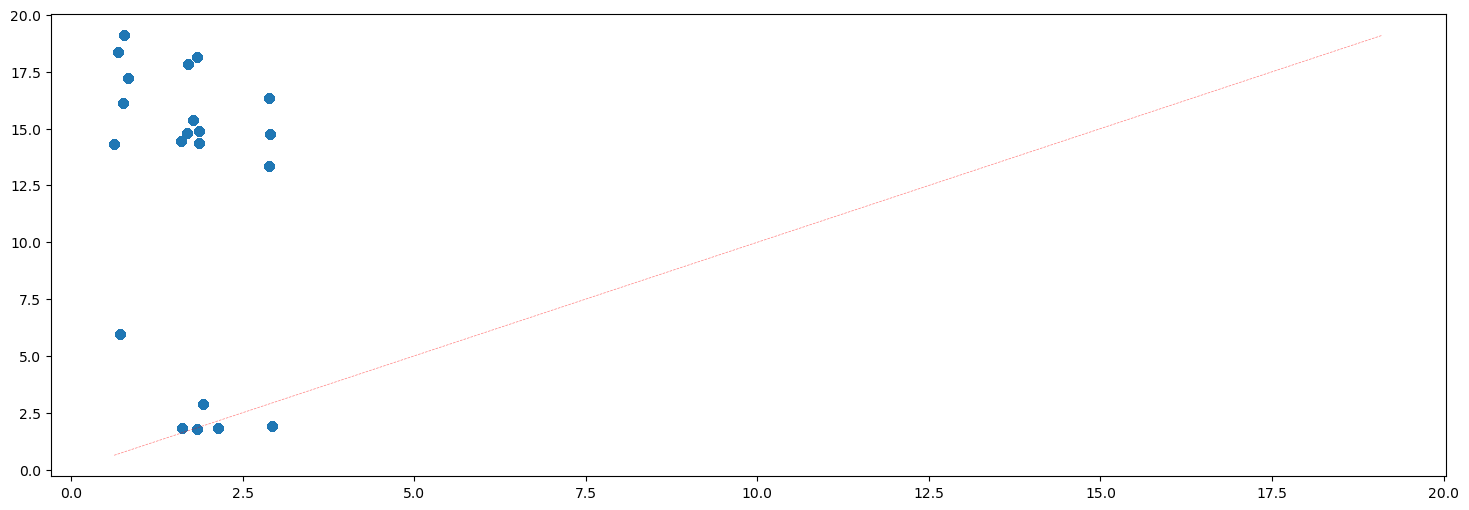

In [20]:

# Fidelity: Separate visualizations for text-based and Virtual Reality (VR) environments
columns_list = [cn for cn in participants_df.columns if cn.endswith('_Text')]
print(columns_list)
y_srs = participants_df[columns_list].T.sum()
columns_list = [cn for cn in participants_df.columns if cn.endswith('_Sim')]
print(columns_list)
x_srs = participants_df[columns_list].T.sum()

fig, ax = plt.subplots(figsize=(18, 6))
path_collection_obj = ax.scatter(x_srs, y_srs, alpha=1.0)

# Calculate the limits for the diagonal line
max_x = max_y = max(max(x_srs), max(y_srs))
min_x = min_y = min(min(x_srs), min(y_srs))

# Draw diagonal line
line2d_objs_list = ax.plot([min_x, max_x], [min_y, max_y], linewidth=.5, color='red', linestyle='--', alpha=.5)

['ST_KDMA_Sim', 'ST_AttribGrp_Sim', 'AD_KDMA_Sim', 'AD_AttribGrp_Sim']
['ST_KDMA_Text', 'ST_AttribGrp_Text', 'AD_KDMA_Text', 'AD_AttribGrp_Text']


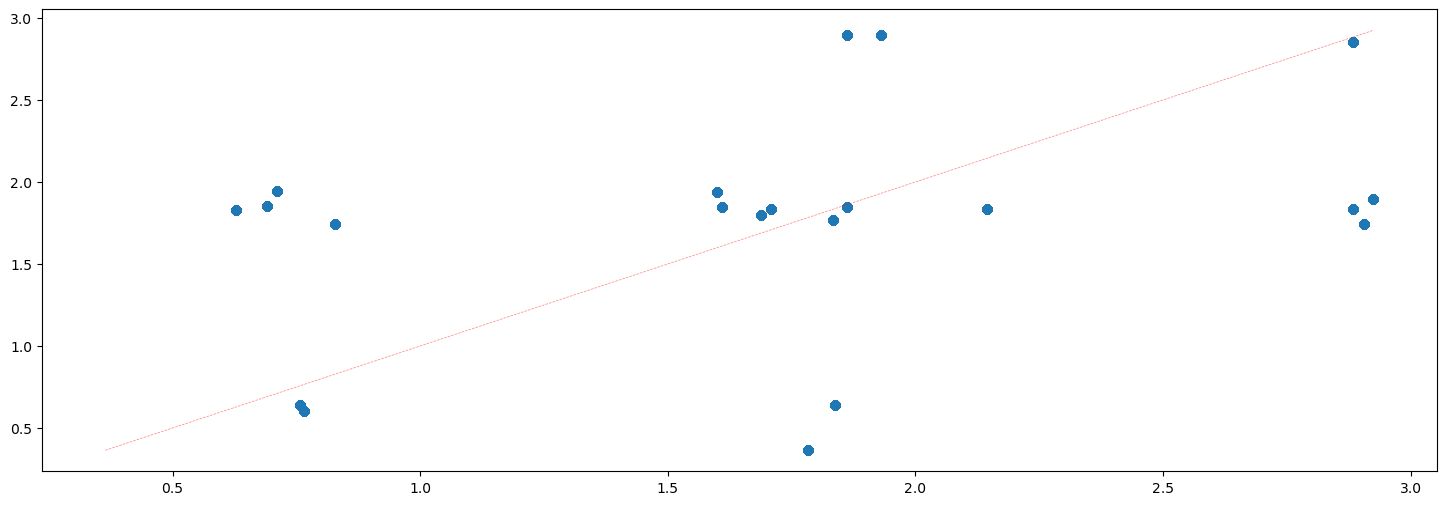

In [19]:

import matplotlib

# Fidelity: Separate visualizations for text-based and Virtual Reality (VR) environments
x_columns_list = [cn for cn in participants_df.columns if cn.endswith('_Sim')]
print(x_columns_list)
x_srs = participants_df[x_columns_list].T.sum()
y_columns_list = [cn.replace('_Sim', '_Text') for cn in x_columns_list]
print(y_columns_list)
y_srs = participants_df[y_columns_list].T.sum()

fig, ax = plt.subplots(figsize=(18, 6))
path_collection_obj = ax.scatter(x_srs, y_srs, alpha=1.0)

# Calculate the limits for the diagonal line
max_x = max_y = max(max(x_srs), max(y_srs))
min_x = min_y = min(min(x_srs), min(y_srs))

# Draw diagonal line
line2d_objs_list = ax.plot([min_x, max_x], [min_y, max_y], linewidth=.5, color='red', linestyle='--', alpha=.5)

Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/ow_participant_scenes_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/ow_participant_scenes_df.csv
['scene_action_count', 'scene_assessment_count', 'scene_tag_application_count', 'scene_treatment_count', 'swaps_to_perfect_order_count', 'time_to_hemorrhage_control', 'treated_expectant_int']


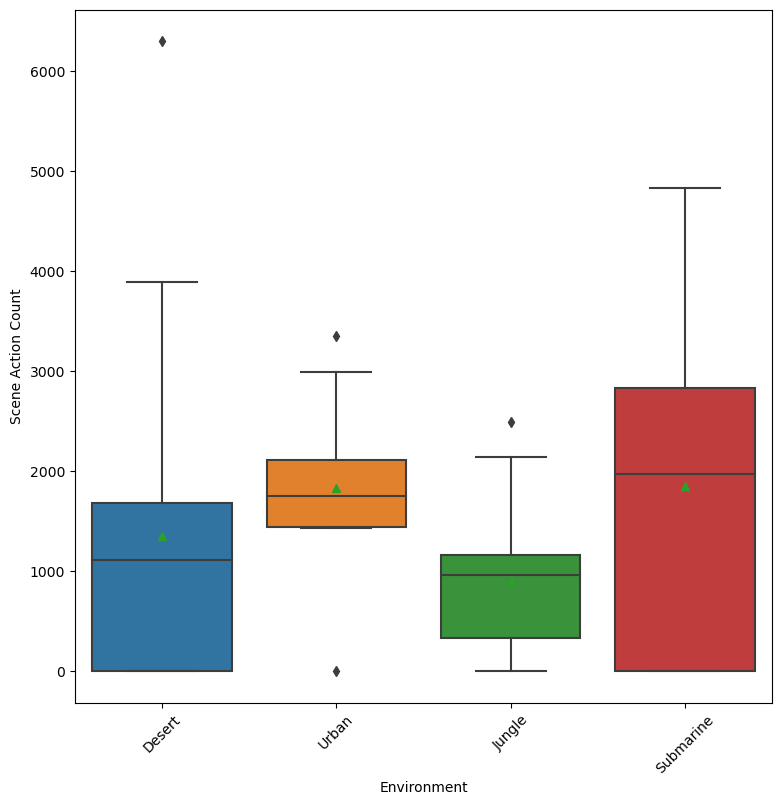

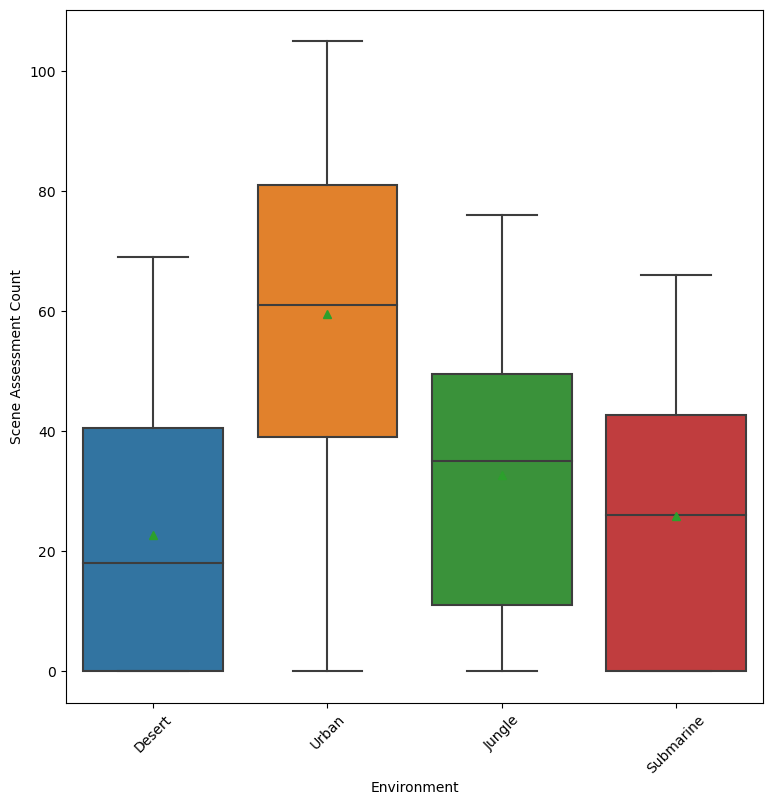

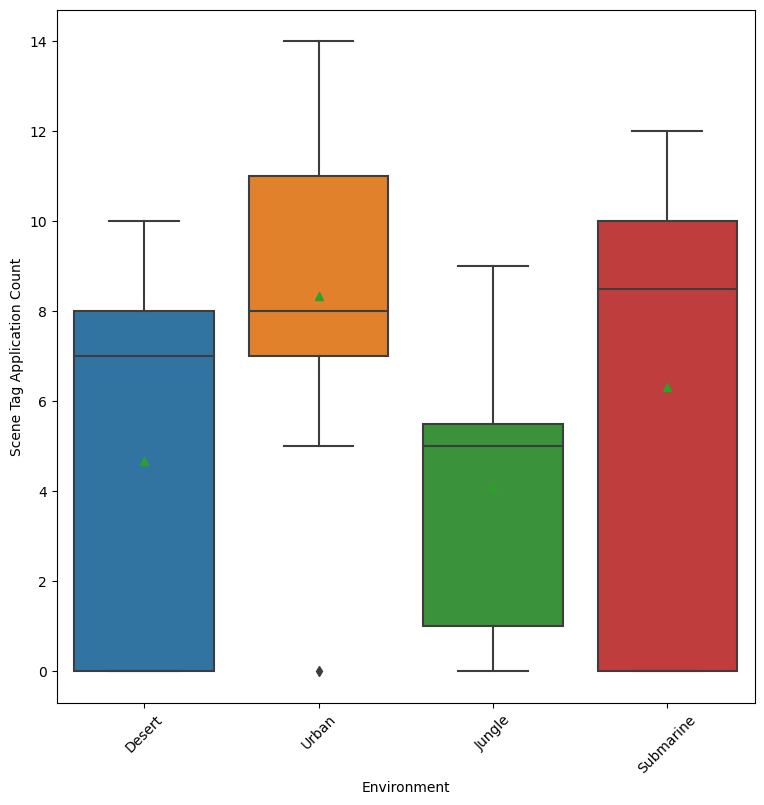

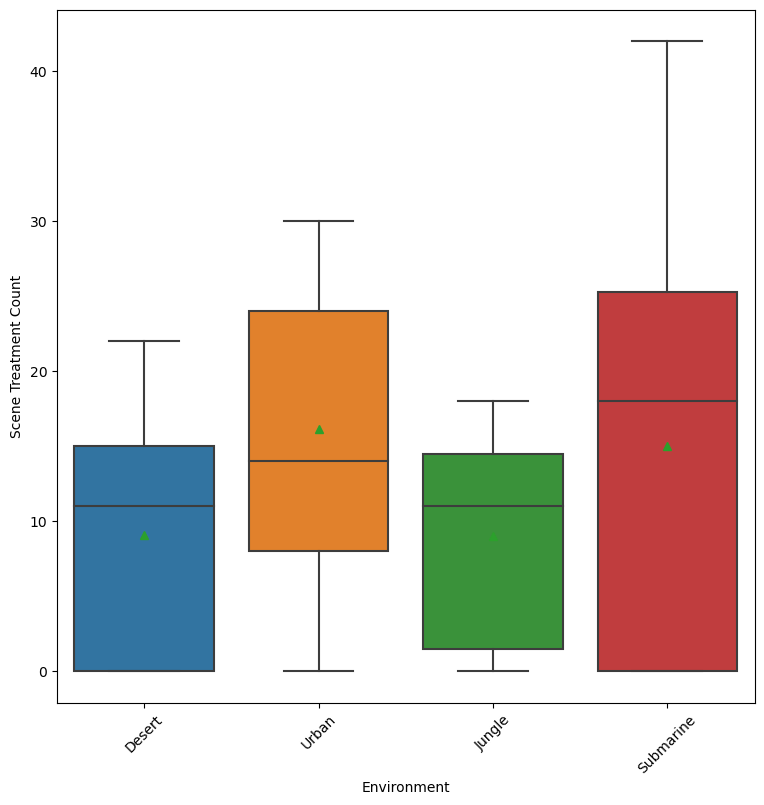

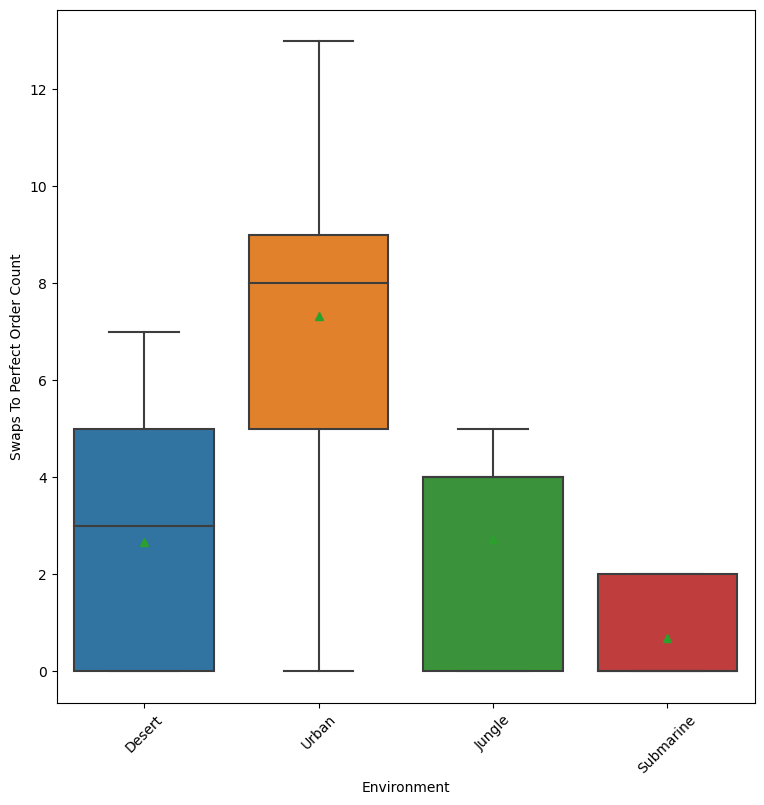

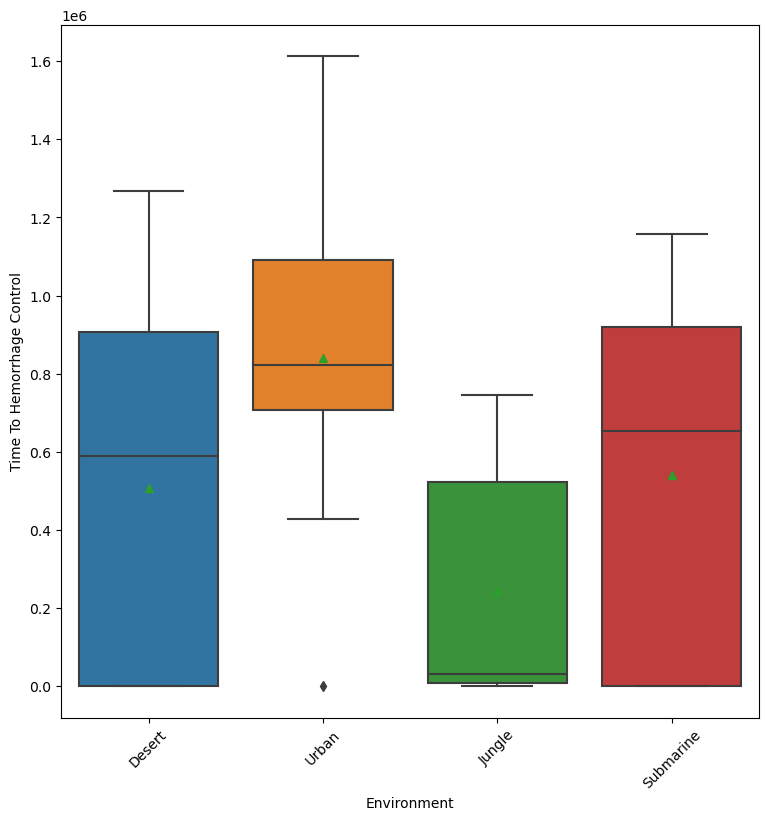

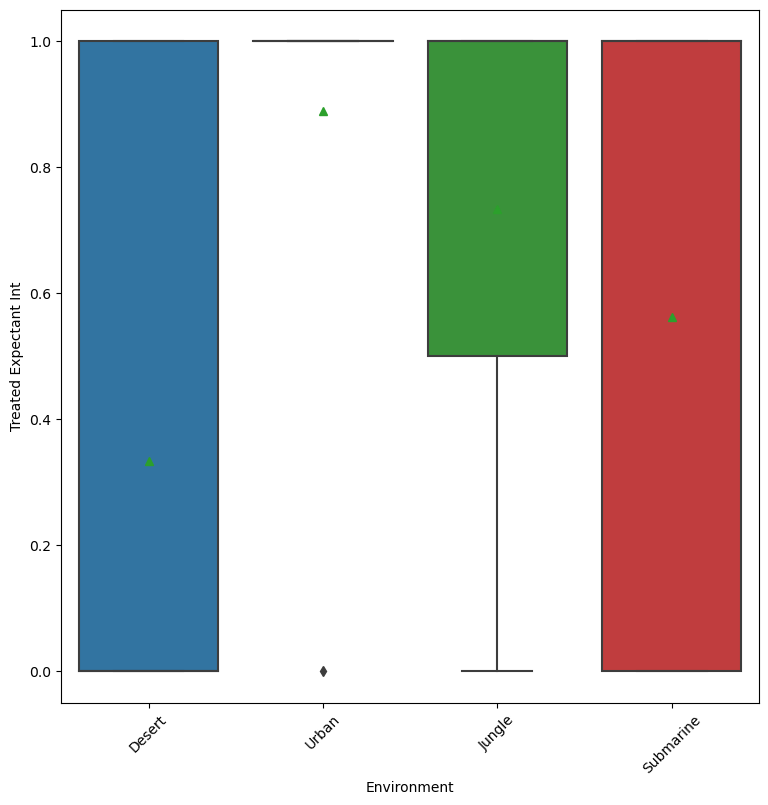

In [24]:

# Environment: Bar charts or boxplots to compare performance metrics between urban, jungle, desert, and suburban environments
if 'treated_expectant_int' not in participant_scenes_df.columns:
    participant_scenes_df['treated_expectant_int'] = participant_scenes_df.treated_expectant.map(lambda x: int(x))
    nu.store_objects(ow_participant_scenes_df=participant_scenes_df)
    nu.save_data_frames(ow_participant_scenes_df=participant_scenes_df)
y_column_names_list = [
    'scene_action_count', 'scene_assessment_count', 'scene_tag_application_count', 'scene_treatment_count', 'swaps_to_perfect_order_count',
    'time_to_hemorrhage_control', 'treated_expectant_int'
]
print(y_column_names_list)
for y_column_name in y_column_names_list:
    fu.plot_grouped_box_and_whiskers(
        participant_scenes_df, 'encounter_layout', y_column_name, 'Environment', ' '.join([s.title() for s in y_column_name.split('_')]),
        transformer_name=None, is_y_temporal=False
    )
    # break

In [ ]:

# Get the columns that consistently have only one value in them per participant
single_value_cols_set = set(participants_df.columns)
for participant_id, df in participants_df.groupby('participant_id'):
    single_value_cols = set([col for col in df.columns if df[col].nunique() == 1])
    single_value_cols_set = single_value_cols_set.intersection(single_value_cols)
print(single_value_cols_set)

In [31]:

# Make a dataset of columns associated with participant ID
print(len(single_value_cols_set))
df = participants_df[single_value_cols_set]
print(df.shape)
df.sample(10).dropna(axis='columns', how='all').T

492
(155930, 492)


,3388,6993,599,3519,4285,2760,4420,1360,940,1681
configData_narrative_narrativeSections10_availableInventory_nasopharyngealAirwayCount,0,0,0,0,0,0,0,0,0,0
configData_narrative_narrativeSections04_availableInventory_burnDressingCount,0,0,0,1,1,0,0,1,1,1
configData_narrative_narrativeSections01_availableInventory_tourniquetCount,0,0,0,0,0,0,0,0,0,0
configData_narrative_narrativeSections00_availableInventory_splintCount,0,0,0,0,0,0,0,0,0,0
configData_narrative_narrativeSections12_audioVolumeSettings_duration,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
configData_narrative_narrativeSections04_availableInventory_hemostaticGauzeCount,0,0,0,0,0,0,0,0,0,0
configData_narrative_narrativeSections01_screenFadeSettings_fadeInOutBlack,False,False,False,False,False,False,False,False,False,False
configData_patientDataList01_injuries_pretreated,False,False,False,False,False,False,False,False,False,False
configData_patientDataList10_positionAngle_position_y,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN


In [116]:

interesting_columns = [cn for cn in single_value_cols_set if (participants_df[cn].nunique() > 1)]
df[interesting_columns].sample(6).dropna(axis='columns', how='all').T

,5186,4200,7442,1969,12256,7103
configData_narrative_narrativeSections04_availableInventory_burnDressingCount,1,1,0,0,0,0
configData_patientDataList10_clothing_bottomTexture,NaN,NaN,5.0,5.0,5.0,5.0
ST_KDMA_Sim,0.405731,0.394278,0.367164,0.361009,0.367164,0.383005
configData_patientDataList00_clothing_shoeTexture,0,0,2,2,2,2
actionList12_answer,,,,,,
configData_patientDataList02_raceEthnicity_hairOverride,False,False,True,True,True,True
configData_patientDataList10_overrides_burnVictim,NaN,NaN,False,False,False,False
ST_AttribGrp_Text,0.0,0.0,1.0,0.0,1.0,0.0
configData_patientDataList10_clothing_bottomColor,NaN,NaN,original,original,original,original
configData_patientDataList07_raceEthnicity_hairOverride,False,False,True,True,True,True


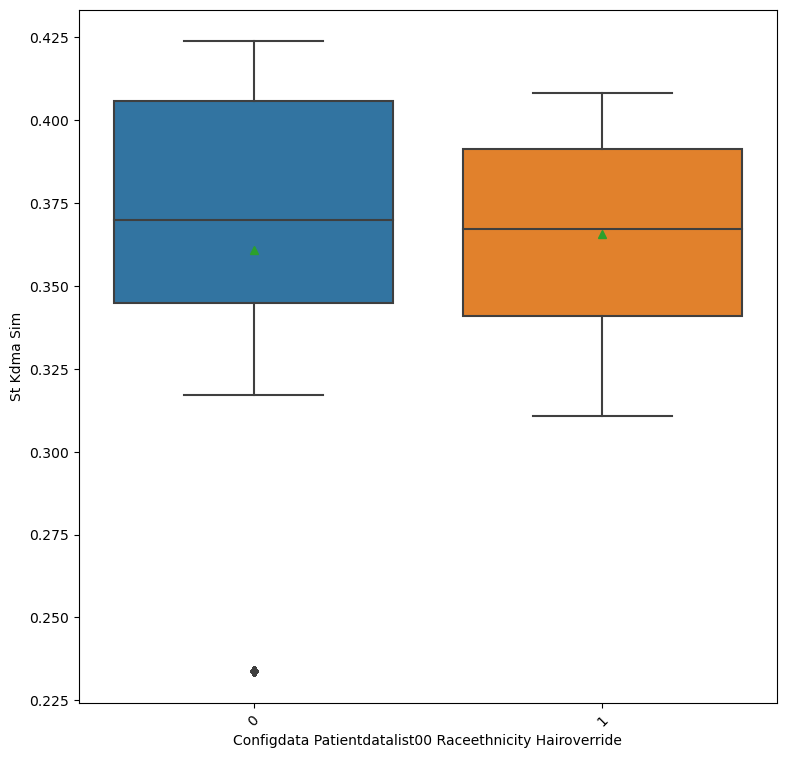

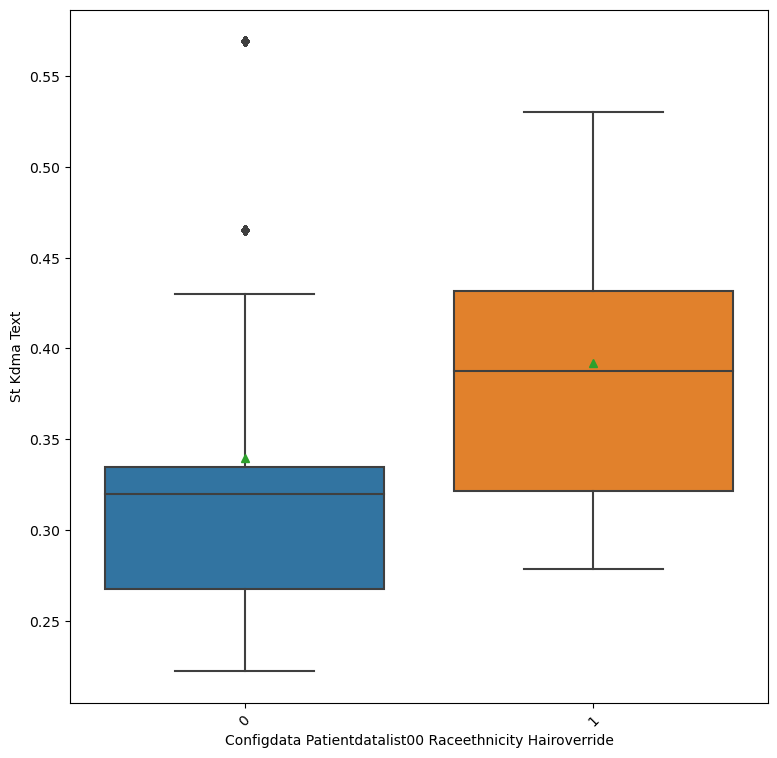

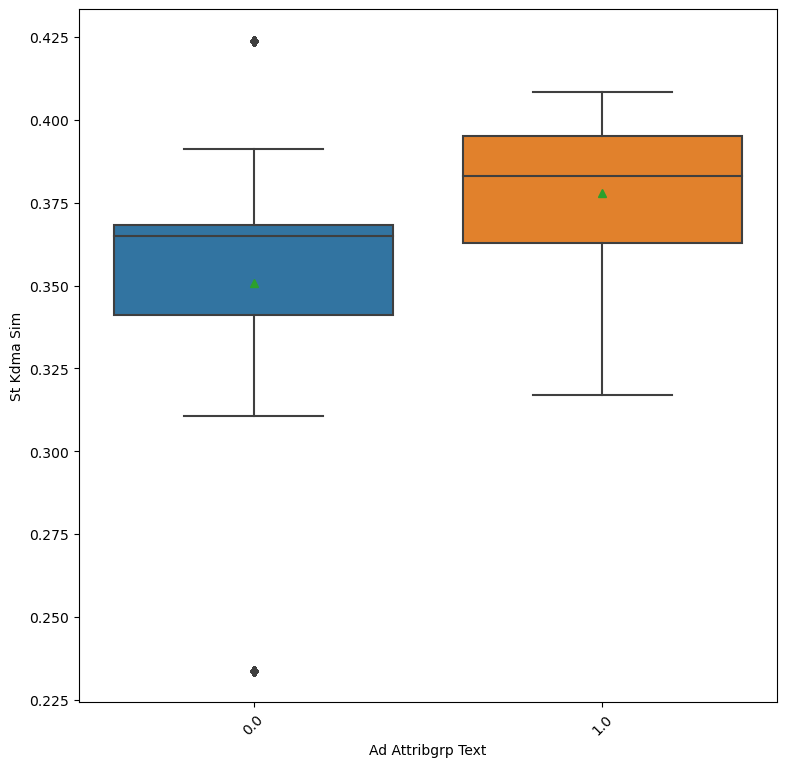

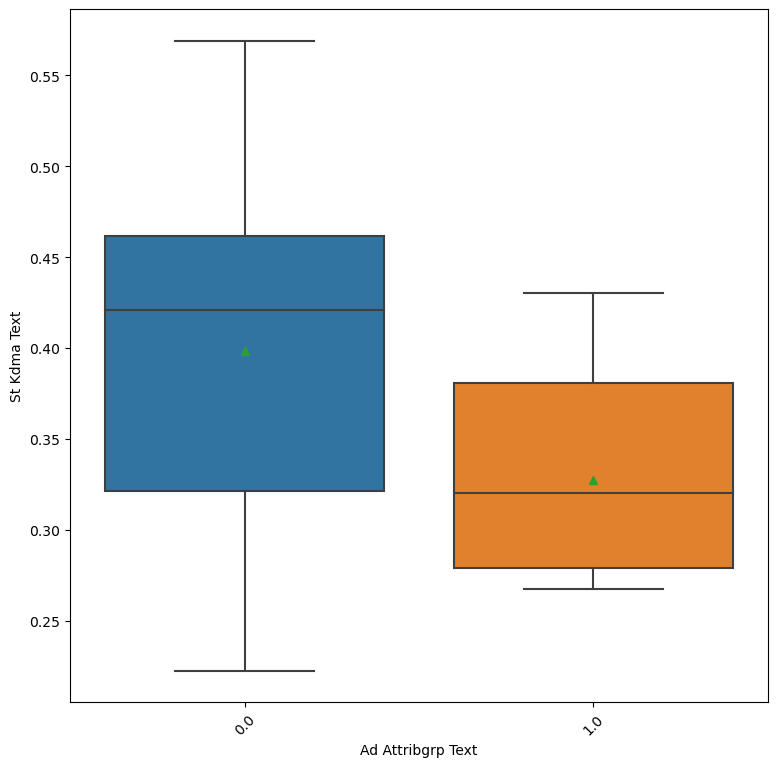

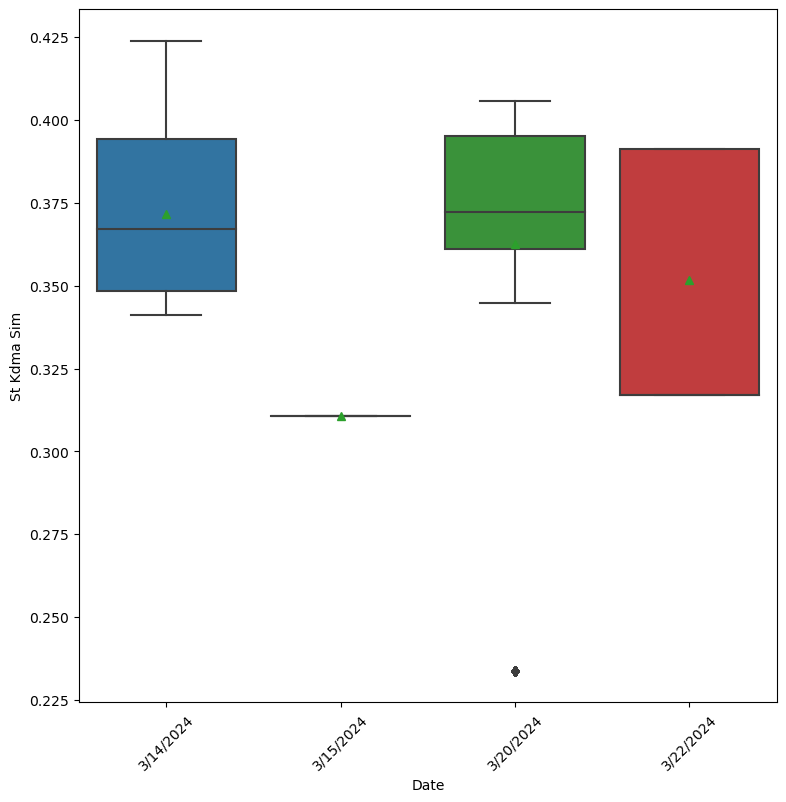

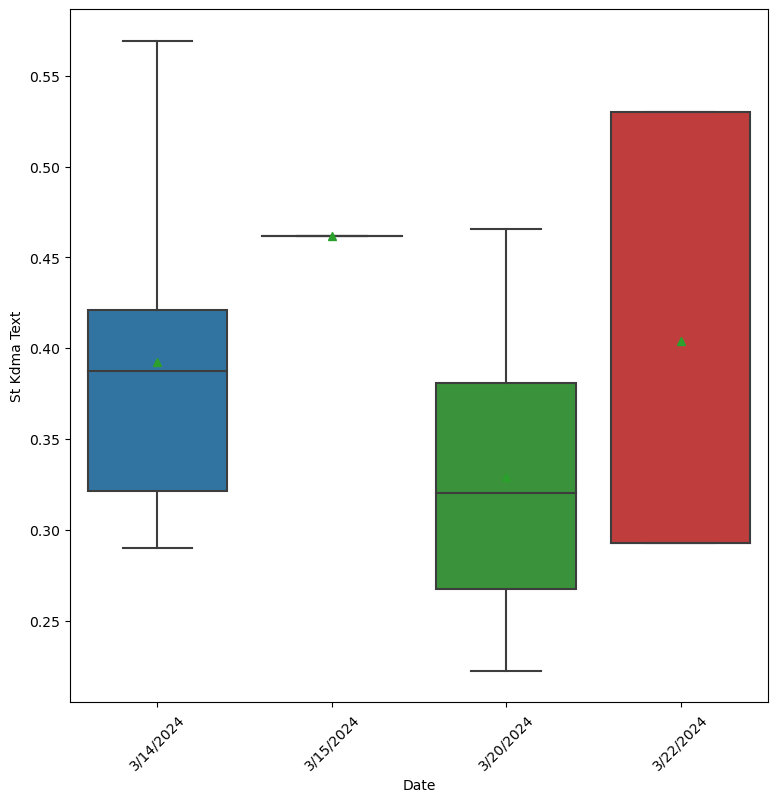

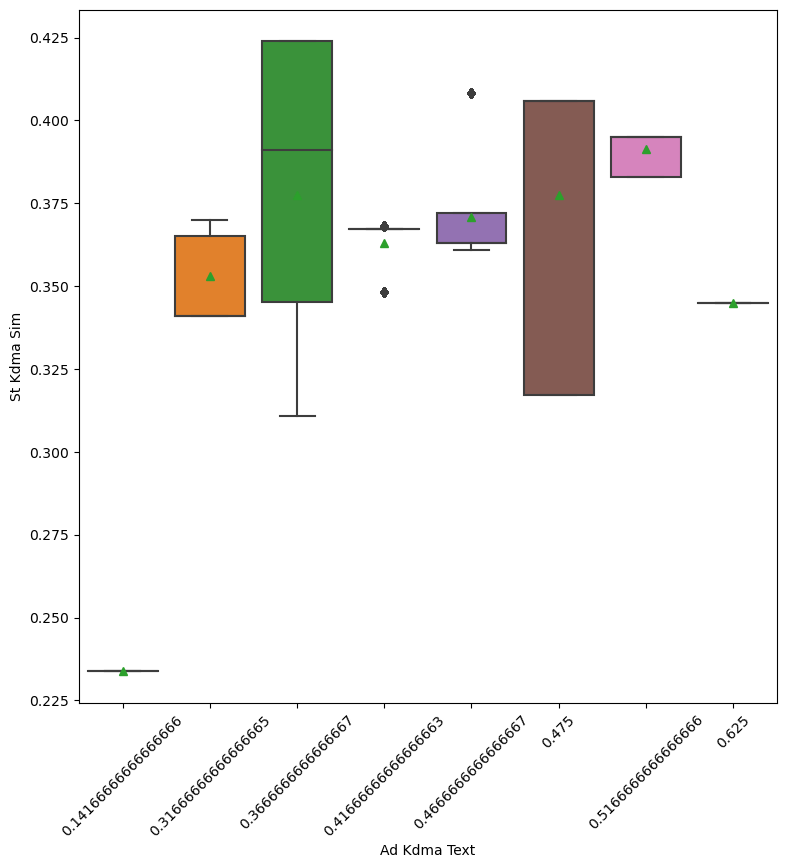

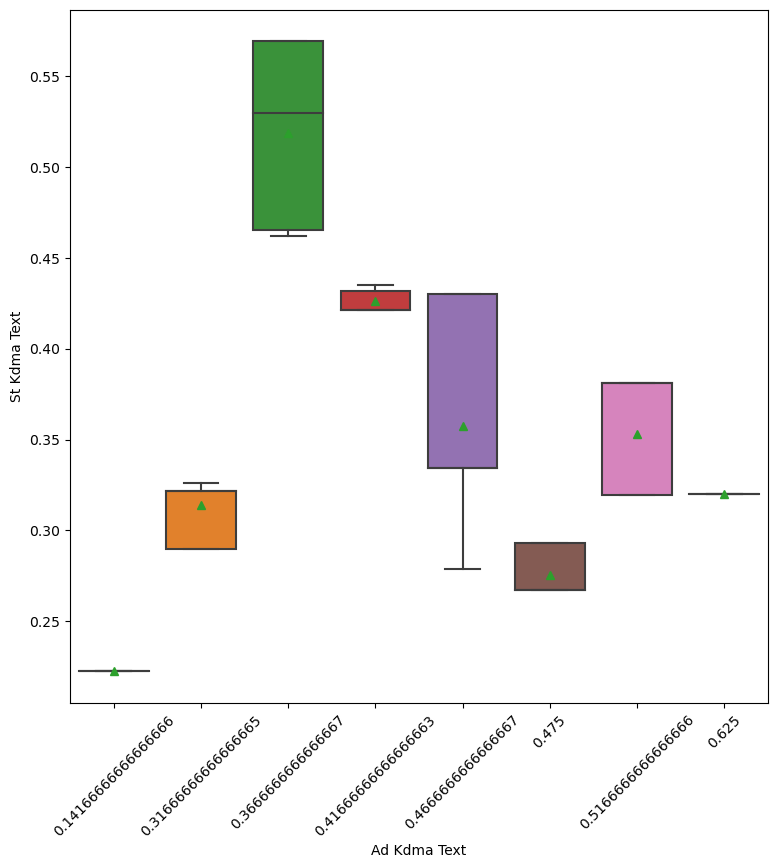

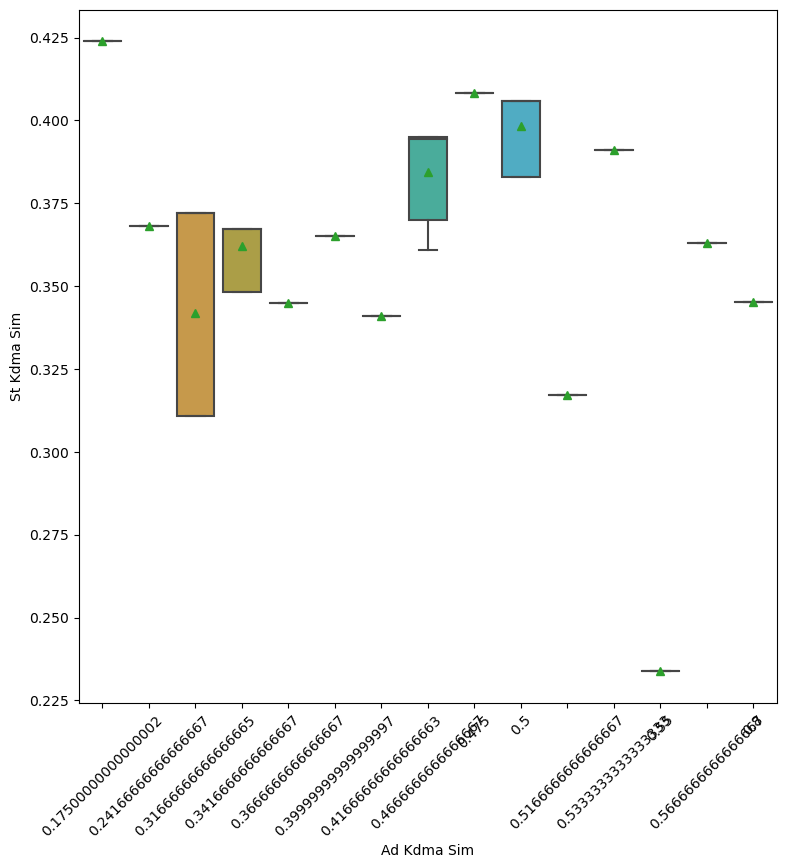

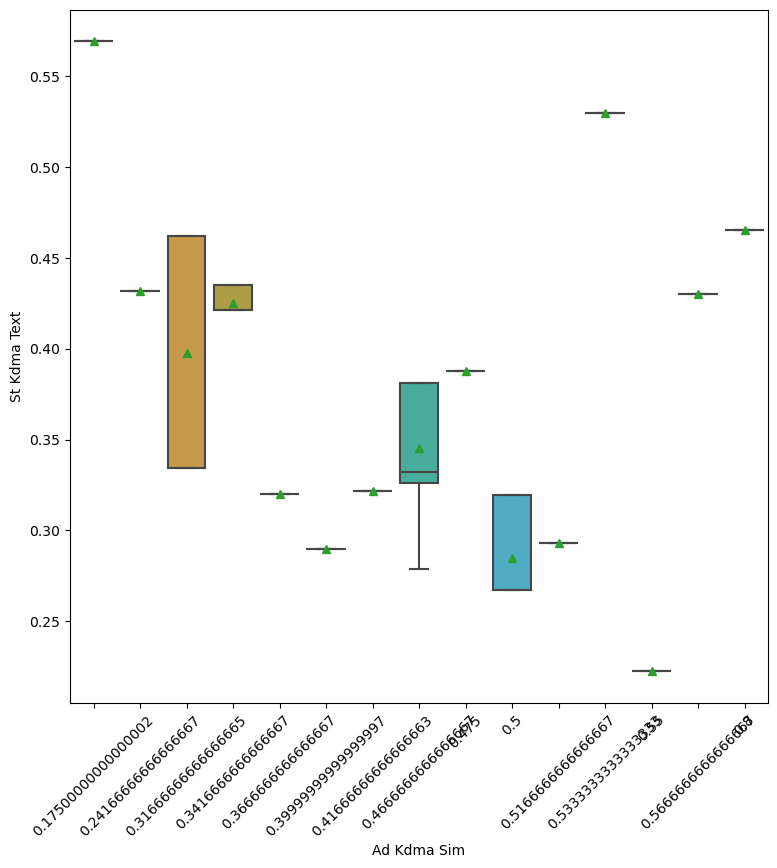

In [114]:

# There are no interesting groupings at the participant level
x_column_names_list = [
    'configData_patientDataList00_raceEthnicity_hairOverride', 'AD_AttribGrp_Text', 'Date', 'AD_KDMA_Text', 'AD_KDMA_Sim'
]#sorted(interesting_columns, key=lambda x: participants_df[x].nunique())[-15:-7]
# for cn in x_column_names_list: print(cn, participants_df[cn].nunique())
y_column_names_list = ['ST_KDMA_Sim', 'ST_KDMA_Text']#sorted(interesting_columns, key=lambda x: participants_df[x].nunique())[-7:]
# for cn in y_column_names_list: print(cn, participants_df[cn].nunique())
# countdown = 5
for x_column_name in x_column_names_list:
    # if countdown < 0: break
    for y_column_name in y_column_names_list:
        # if countdown < 0: break
        x_label = ' '.join([s.title() for s in x_column_name.split('_')])
        y_label = ' '.join([s.title() for s in y_column_name.split('_')])
        if participants_df[x_column_name].dtype == bool:
            participants_df[x_column_name] = participants_df[x_column_name].astype(int)
        try:
            fu.plot_grouped_box_and_whiskers(
                participants_df, x_column_name, y_column_name, x_label,
                y_label, transformer_name=None, is_y_temporal=False
            )
        except Exception as e:
            print(f'{e.__class__} error trying to plot_grouped_box_and_whiskers: {str(e).strip()}')
            print(
                x_column_name, participants_df[x_column_name].unique().tolist(), y_column_name, participants_df[y_column_name].unique().tolist()
            )
        # countdown -= 1

In [ ]:

# Create the numeric single value columns
def is_numeric(value):
    try:
        float(value)
        return not pd.isna(value)
    except ValueError: pass
    except TypeError: return False
    try:
        int(value)
        return True
    except ValueError: return False
numeric_single_value_cols_list = []
for cn in single_value_cols_set:
    if participants_df[cn].map(lambda x: is_numeric(x)).all(): numeric_single_value_cols_list.append(cn)

# Add all the numeric single value columns as means
if any(map(lambda cn: f'mean_{cn}' not in participant_scenes_df.columns, numeric_single_value_cols_list)):
    for cn in numeric_single_value_cols_list:
        if f'mean_{cn}' not in participant_scenes_df.columns:
            for (session_uuid, scene_id), scene_df in participant_scenes_df.groupby(fu.scene_groupby_columns):
                mask_series = (participants_df.session_uuid == session_uuid) & (participants_df.scene_id == scene_id)
                mean_numeric_value = participants_df[mask_series][cn].mean()
                mask_series = (participant_scenes_df.session_uuid == session_uuid) & (participant_scenes_df.scene_id == scene_id)
                participant_scenes_df.loc[mask_series, f'mean_{cn}'] = mean_numeric_value
    nu.store_objects(ow_participant_scenes_df=participant_scenes_df)
    nu.save_data_frames(ow_participant_scenes_df=participant_scenes_df)

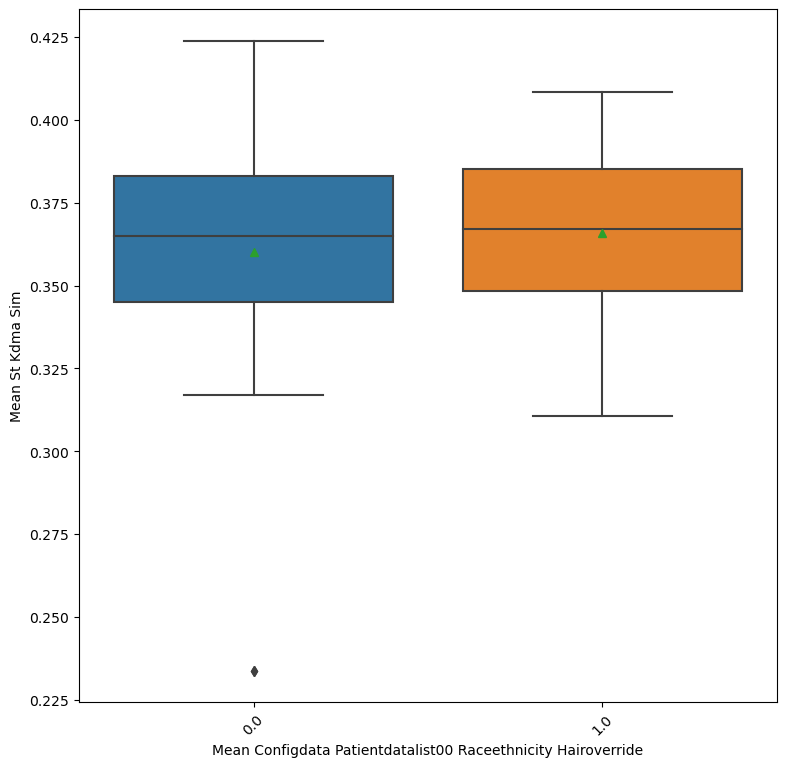

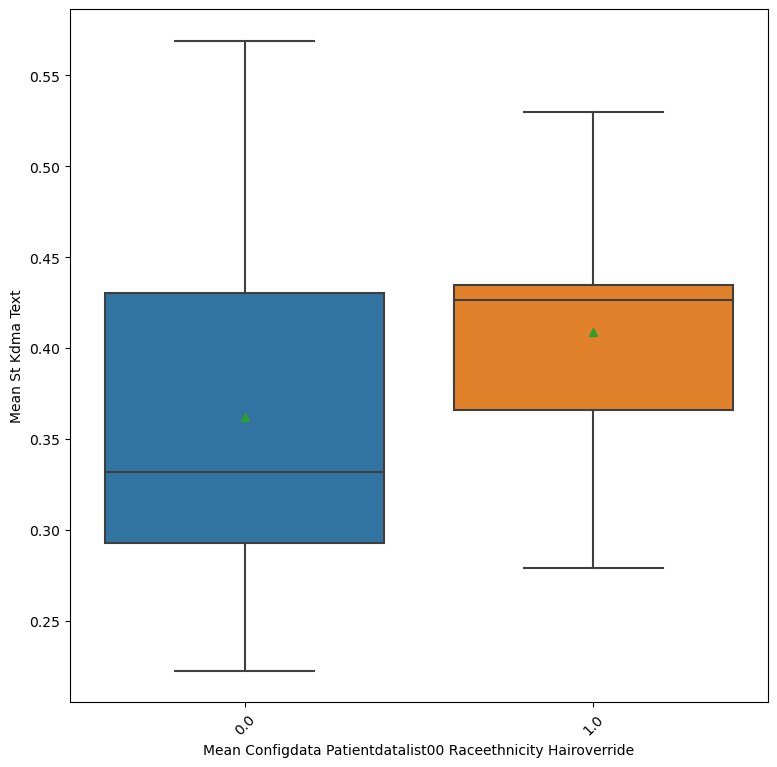

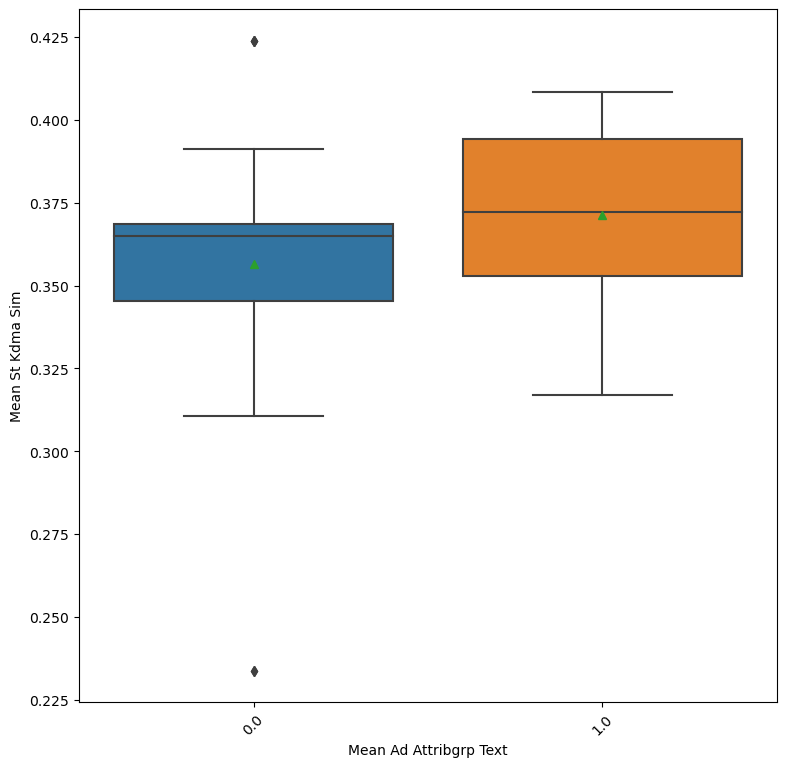

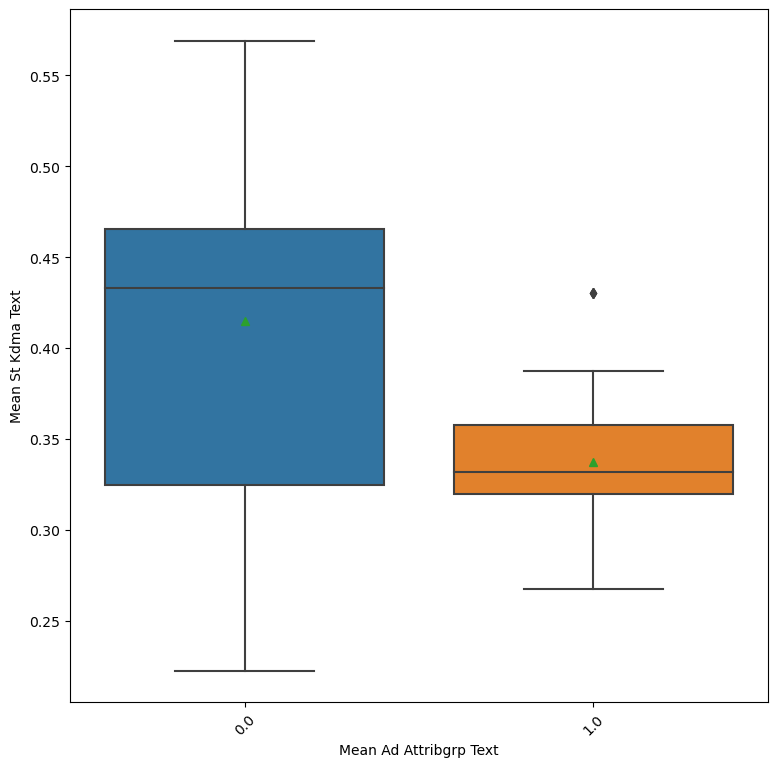

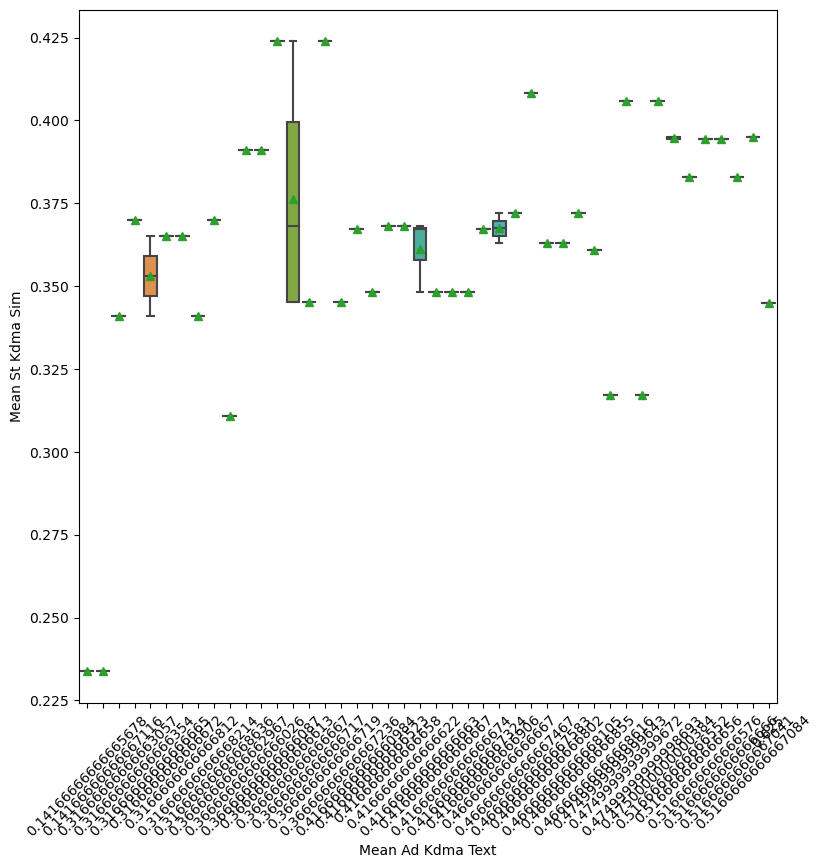

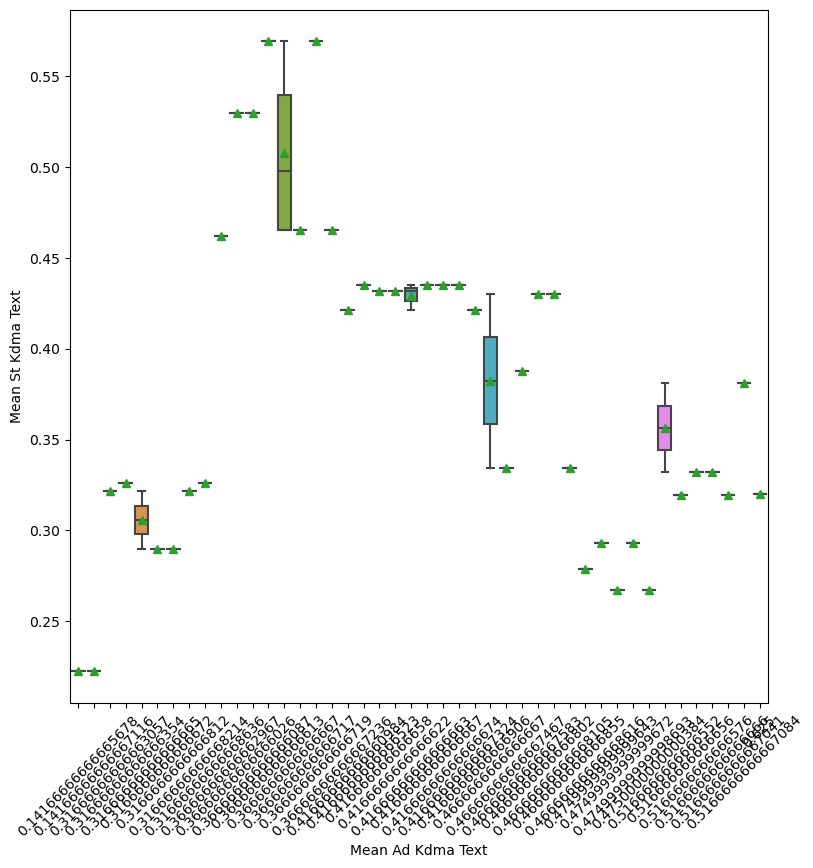

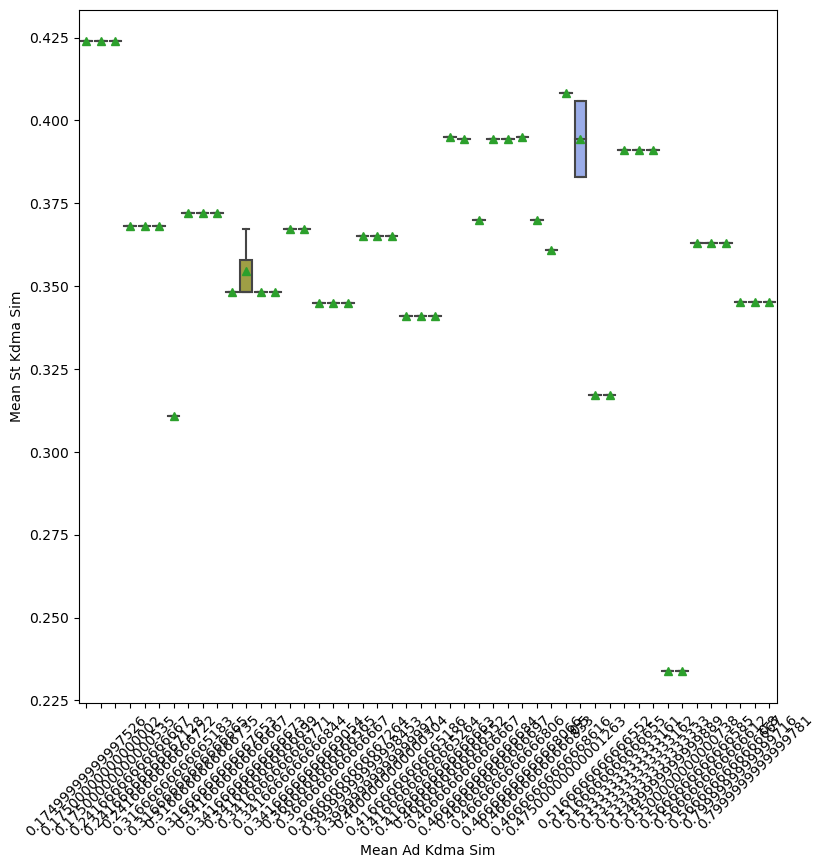

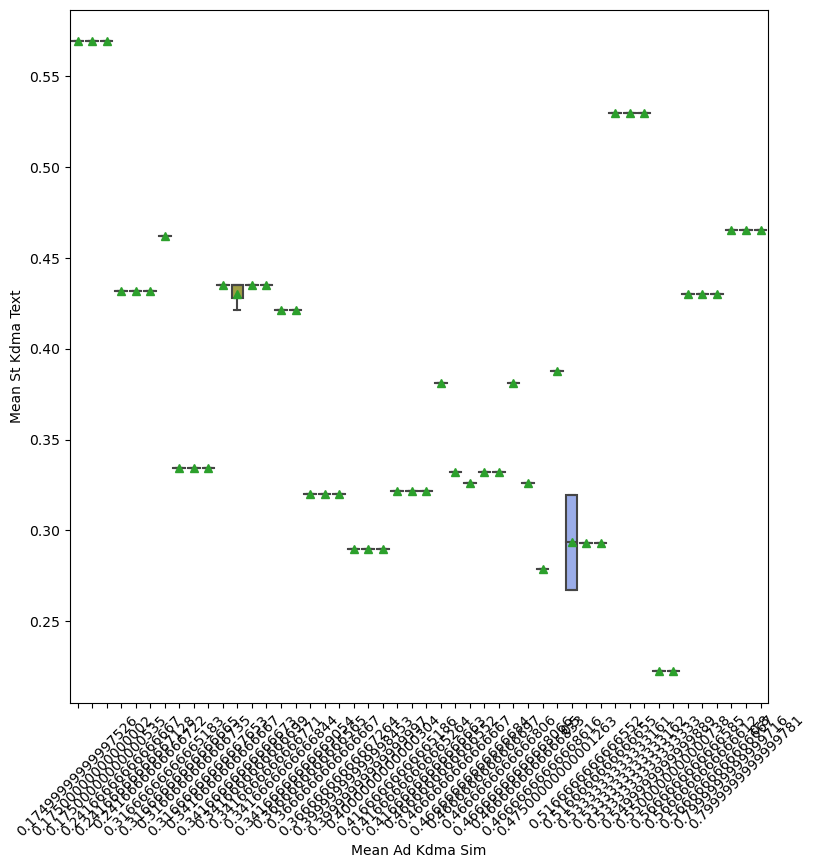

In [134]:

for x_column_name in x_column_names_list:
    for y_column_name in y_column_names_list:
        if (f'mean_{x_column_name}' in participant_scenes_df.columns) and (f'mean_{y_column_name}' in participant_scenes_df.columns):
            x_label = ' '.join([s.title() for s in f'mean_{x_column_name}'.split('_')])
            y_label = ' '.join([s.title() for s in f'mean_{y_column_name}'.split('_')])
            try:
                fu.plot_grouped_box_and_whiskers(
                    participant_scenes_df, f'mean_{x_column_name}', f'mean_{y_column_name}', x_label,
                    y_label, transformer_name=None, is_y_temporal=False
                )
            except Exception as e:
                print(f'{e.__class__} error trying to plot_grouped_box_and_whiskers: {str(e).strip()}')
                print(
                    f'mean_{x_column_name}', participant_scenes_df[f'mean_{x_column_name}'].unique().tolist(),
                    f'mean_{y_column_name}', participant_scenes_df[f'mean_{y_column_name}'].unique().tolist()
                )

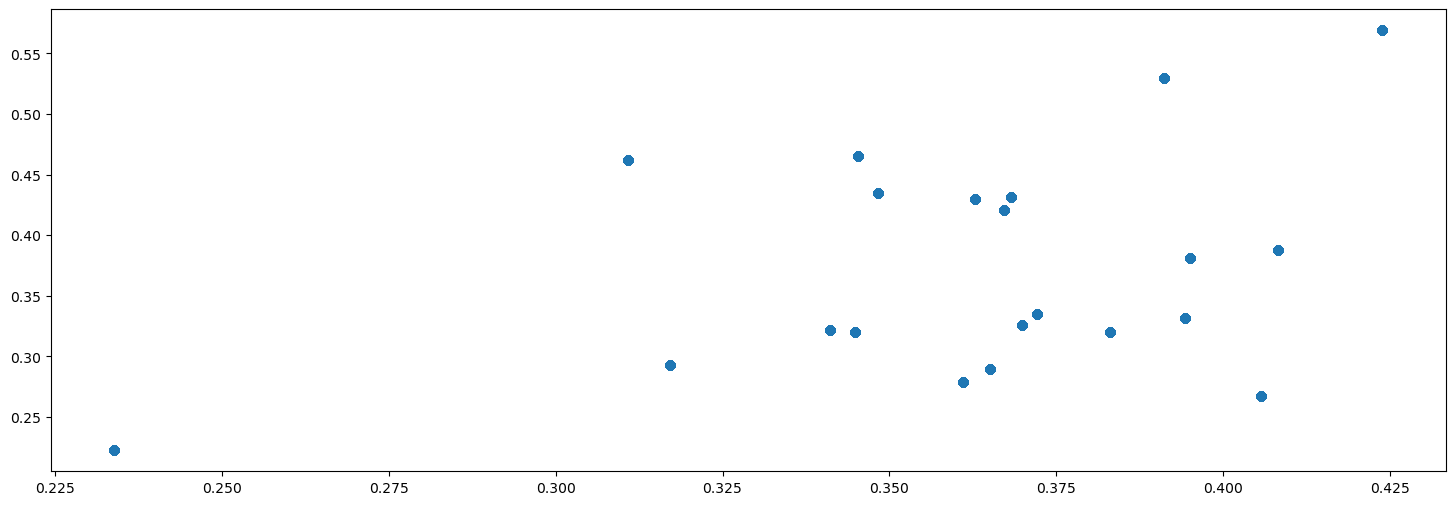

In [72]:

x_srs = participants_df.ST_KDMA_Sim
y_srs = participants_df.ST_KDMA_Text

fig, ax = plt.subplots(figsize=(18, 6))
path_collection_obj = ax.scatter(x_srs, y_srs, alpha=1.0)

In [137]:

columns_list = [cn for cn in participant_scenes_df.columns if (participant_scenes_df[cn].nunique() > 1)]
for cn in sorted(columns_list, key=lambda cn: participant_scenes_df[cn].nunique()): print(participant_scenes_df[cn].nunique(), cn)

2 treated_expectant
2 treated_expectant_int
2 mean_configData_narrative_narrativeSections04_availableInventory_burnDressingCount
2 mean_configData_patientDataList00_clothing_shoeTexture
2 mean_configData_patientDataList02_raceEthnicity_hairOverride
2 mean_ST_AttribGrp_Text
2 mean_configData_patientDataList07_raceEthnicity_hairOverride
2 mean_configData_narrative_narrativeSections09_availableInventory_decompressionNeedleCount
2 mean_configData_narrative_narrativeSections08_availableInventory_pulseOximeterAvailable
2 mean_configData_patientDataList08_clothing_bottomTexture
2 mean_configData_narrative_narrativeSections09_availableInventory_pulseOximeterAvailable
2 mean_configData_narrative_narrativeSections11_autoplay
2 mean_ST_AttribGrp_Sim
2 mean_configData_narrative_narrativeSections04_availableInventory_tourniquetCount
2 mean_AD_AttribGrp_Sim
2 mean_configData_narrative_narrativeSections04_availableInventory_pressureBandageCount
2 mean_configData_patientDataList00_raceEthnicity_hairOv

In [139]:

participant_scenes_df.scene_id.unique()

array([0, 1, 2, 3])


----

In [ ]:

anova_df = DataFrame([])
        # Set priority group column
        mask_series = participants_df.patient_id.isin(priority_group_dict.keys())
        if mask_series.any():
            participants_df.loc[mask_series, 'priority_group'] = participants_df.loc[mask_series, 'patient_id'].map(priority_group_dict)
        
        # Get patient sort dictionary
        mask_series = ~participants_df.patient_sort.isnull()
        patient_sort_dict = participants_df[mask_series].set_index('patient_id').patient_sort.to_dict()
        
        # Set patient sort column
        mask_series = participants_df.patient_id.isin(patient_sort_dict.keys())
        if mask_series.any():
            participants_df.loc[mask_series, 'patient_sort'] = participants_df.loc[mask_series, 'patient_id'].map(patient_sort_dict)
        
        # Get the patient stats
        participant_patient_stats_df = fu.get_patient_stats_data_frame(participants_df, verbose=False)
        
        # Create the tag-to-SALT data frame
        tag_to_salt_df = fu.get_is_tag_correct_data_frame(participants_df, groupby_column='encounter_layout')
        
        # Get the percentage tag correct counts for each scene for each group
        correct_count_by_tag_df = fu.get_percentage_tag_correct_data_frame(tag_to_salt_df, groupby_column='encounter_layout')
        
        # Create the ANOVA data frame
        rows_list = []
        for encounter_layout, encounter_layout_df in participant_patient_stats_df.groupby('encounter_layout'):
            patients_list = eval(f'{encounter_layout.lower()}_patients_list')
            encounter_layout_dict = {}
            for cn in encounter_layout_df.columns:
                if 'swap' in cn:
                    print(cn); raise
                    actual_sequence, ideal_sequence, sort_dict = eval(f'fu.get_actual_and_ideal_{cn}_sequences(scene_df)')
                    unsort_dict = {v1: k for k, v in sort_dict.items() for v1 in v}
                    encounter_layout_dict[cn] = nu.count_swaps_to_perfect_order(
                        [unsort_dict[i] for i in ideal_sequence], [unsort_dict[a] for a in actual_sequence]
                    )
            for (session_uuid, scene_id), scene_df in encounter_layout_df.groupby(fu.scene_groupby_columns):
                mask_series = scene_df.patient_id.isin(patients_list)
                if mask_series.any():
                    row_dict = {'participant_id': participant_id, 'Environment': encounter_layout, 'session_uuid': session_uuid, 'scene_id': scene_id}
                    for cn in participant_columns: row_dict[cn] = participants_df[cn].mean()
                    for cn in ['priority_group', 'patient_sort']:
                        if cn in encounter_layout_dict: row_dict[f'swaps_to_perfect_{cn}_order_count'] = encounter_layout_dict[cn]
        
                    # Get the start of the whole scene
                    scene_mask_series = True
                    for cn in fu.scene_groupby_columns: scene_mask_series &= (participants_df[cn] == eval(cn))
                    scene_start = fu.get_scene_start(participants_df[scene_mask_series])
                    
                    row_dict['mean_first_patient_interaction'] = scene_df.first_patient_interaction.map(lambda x: x - scene_start).mean()
                    row_dict['mean_last_patient_interaction'] = scene_df.last_patient_interaction.map(lambda x: x - scene_start).mean()
                    row_dict['total_patient_engagement_count'] = scene_df.patient_engagement_count.sum()
                    row_dict['total_assessment_count'] = scene_df.assessment_count.sum()
                    row_dict['total_treatment_count'] = scene_df.treatment_count.sum()
                    row_dict['total_tag_application_count'] = scene_df.tag_application_count.sum()
                    row_dict['max_time_to_hemorrhage_control'] = scene_df.time_to_hemorrhage_control.max() - scene_start
        
                    mask_series = (scene_df.treated_expectant == 'yes')
                    row_dict['treated_expectant'] = mask_series.any()
        
                    # Get the whole scene history
                    scene_df = participants_df[scene_mask_series]
                    mask_series = scene_df.patient_id.isin(patients_list)
                    
                    row_dict['triage_time'] = fu.get_triage_time(scene_df[mask_series])
                    row_dict['time_to_last_hemorrhage_controlled'] = fu.get_time_to_last_hemorrhage_controlled(scene_df[mask_series])
                    
                    # Duration of time from when the patient was first approached by the participant until
                    # the time hemorrhage treatment was applied (with a tourniquet or wound packing)
                    row_dict['time_to_hemorrhage_control_per_patient'] = fu.get_time_to_hemorrhage_control_per_patient(scene_df)
                    
                    mask_series = (correct_count_by_tag_df.session_uuid == session_uuid) & (correct_count_by_tag_df.scene_id == scene_id)
                    if mask_series.any():
                        row_dict['mean_percentage_tag_correct'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()
                    
                    rows_list.append(row_dict)
        participant_anova_df = DataFrame(rows_list)
        
        # Append the data frame for the current participant to the main data frame
        anova_df = concat([anova_df, participant_anova_df], axis='index')

swaps_to_perfect_patient_sort_order_count


RuntimeError: No active exception to reraise


## Create separate graphs or tables for the following measures (DVs) by environment (urban, jungle, desert, sub) and by fidelity (text, sim) and by performer (ADEPT, SOARTECH)
<ul>
    <li>Total number of actions</li>
    <li>Count of assessment actions</li>
    <li>Count of treatment actions</li>
    <li>Count of tags applied</li>
    <li>Order of patients engaged</li>
    <li>Tag color for each patient</li>
    <li>Treat expectant patient (yes/no)</li>
    <li>Triage efficiency</li>
    <li>Time to hemorrhage control</li>
</ul>

In [12]:

[cn for cn in scene_df.columns if cn in ['priority_group', 'patient_sort']]

['patient_sort']

In [7]:

print(anova_df.Environment.unique().tolist())
columns_list = ['total_action_count', 'total_assessment_count', 'total_treatment_count', 'total_tag_application_count']
for encounter_layout, encounter_layout_df in anova_df.groupby('Environment'):

['Desert', 'Urban', 'Jungle', 'Submarine']


<ul>
    <li>Explore / create other DVs from the sim that might be indicative of something (movement, what they say, other observables). Can we glean anything else from the logs given what you have explored from the subway dataset?</li>
    <li>Determine which of the above DVs shows a good amount of variability (share the results from above with the group)</li>
    <li>
        Then group or try to predict (through regression or ML or anything else) any of the DVs using the following IVs:
        <ul>
            <li>Participant medical role</li>
            <li>AD alignment score (continuous or group assignment)</li>
            <li>ST alignment score (continuous or group assignment)</li>
            <li>Years of experience</li>
        </ul>
    </li>
</ul>


Conduct some exploratory analysis of the open world segments for the ITM scenarios from the Metrics Evaluation.
For context, results of these analyses is a goal for the 4/30 results meeting (stretch) or the PI meeting (more likely).

<h2>Which factors contribute to the variance in these outcomes?</h2>
Conceptually, I want an exploratory factor analysis using these IVs and DVs. But I suspect we don’t have enough data for that so as close as we can get to that, let’s get creative.
My thought was to keep the environments separate because each participant did 2 of the environments so if we use 1 to explore, we can use the other to confirm. But again, I recognize we do not have power to do these properly.

In [4]:

# Add file and scene columns to the 11-patient scenes
participant_columns = [
    'ST_Del_Text', 'AD_AttribGrp_Sim', 'Trust', 'ST_ConfFC_Text', 'Delegation', 'YrsMilExp', 'AD_Del_Text', 'MedExp', 'AD_AttribGrp_Text',
    'ST_ConfFC_Omni_Text', 'PropTrust', 'ST_KDMA_Text', 'AD_KDMA_Text', 'ST_AttribGrp_Text', 'ST_Del_Omni_Text', 'MilitaryExp', 'AD_ConfFC_Omni_Text',
    'MedRole', 'ST_AttribGrp_Sim', 'AD_ConfFC_Text', 'ST_KDMA_Sim', 'AD_Del_Omni_Text', 'AD_KDMA_Sim'
]
needed_columns = [
    'scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'configData_scene',
    'configData_scenarioData_name', 'configData_scenarioData_description', 'encounter_layout', 'participantId', 'ParticipantID', 'Sim1', 'Sim2'
] + participant_columns

In [6]:

filter_fn = lambda scene_df: scene_df.session_uuid.isin(json_stats_uuids).any()
elevens_df = fu.get_elevens_data_frame(
    logs_df, json_stats_df, scene_stats_df, needed_columns=needed_columns, patient_count_filter_fn=filter_fn
)
print(elevens_df.shape) # (85851, 142)

(76936, 142)



## There should be a total of 23 participants labeled 2024201 to 2024223

In [7]:

# Create a table of the count of JSON files that have the participant ID suffixed to their file name
from IPython.display import HTML

logs_path = '../data/logs/Metrics Evaluation Open World'
rows_list = []
for participant_id in range(2_024_201, 2_024_223+1):
    mask_series1 = (json_stats_df.ParticipantID == participant_id)
    mask_series2 = (json_stats_df.participantId == participant_id)
    # print(
    #     participant_id,
    #     json_stats_df[mask_series1].shape[0],
    #     json_stats_df[mask_series2].shape[0]
    # )
    row_dict = {'participant_id': participant_id}
    file_count = 0
    for sub_directory, directories_list, files_list in os.walk(logs_path):
        for file_name in files_list:
            if file_name.endswith('.json') and ('_' in file_name):
                if (file_name.split('_')[1].split('.')[0] == str(participant_id)):
                    file_count += 1
    row_dict['file_count'] = file_count
    # print(participant_id, file_count, 'files with the participant ID in the file name')
    rows_list.append(row_dict)
print()
caption_regex = re.compile(r'<table([^>]*)>(\s*)')
regex_str = r'<table\1>\2<caption>This is the new table of the<br />count of JSON files that have<br />the'
regex_str += r' participant ID suffixed to<br />their file name:</caption>\2'
html_str = caption_regex.sub(regex_str, DataFrame(rows_list).to_html(), 1)
html_str = re.sub(r'\s+<th>\d*</th>', '', html_str)
HTML(html_str)

participant_id,file_count
2024201,2
2024202,2
2024203,2
2024204,2
2024205,2
2024206,2
2024207,2
2024208,2
2024209,2
2024210,0


In [8]:

# Check out the various sub directories associated with participant JSON files
rows_list = []
for participant_id in range(2_024_201, 2_024_223+1):
    for sub_directory, directories_list, files_list in os.walk(logs_path):
        for file_name in files_list:
            if file_name.endswith('.json') and ('_' in file_name):
                if (file_name.split('_')[1].split('.')[0] == str(participant_id)):
                    directory_suffix = sub_directory.replace('../data/logs/Metrics Evaluation Open World/', '')
                    folder_names_list = re.split('/', directory_suffix, 0)
                    row_dict = {'participant_id': participant_id}
                    for i, folder_name in enumerate(folder_names_list): row_dict[f'folder{i}'] = folder_name
                    rows_list.append(row_dict)
df = DataFrame(rows_list)
folders_df = DataFrame([])
groupby_columns = ['participant_id', 'folder0']
for (participant_id, folder0), folder0_df in df.groupby(groupby_columns):
    folders_df = pd.concat([folders_df, folder0_df], axis='index').reset_index(drop=True)
folders_df.sort_values(['participant_id'] + [f'folder{i}' for i in range(len(folders_df.columns)-1)])

,participant_id,folder0
0,2024201,23081f6e-875e-44f5-8bd0-edc3905f5c2c_2024201
1,2024201,bccb0095-5efd-4c5c-ad58-8b8624f9ab56_2024201
2,2024202,220b609b-0e35-454e-9afd-c84cbfa3e3ad_2024202
3,2024202,922ad146-241a-4ea6-8ff1-413d7e0d16ec_2024202
4,2024203,4bc46c8c-66e7-463d-b3a1-2a8303af4fd1_2024203
5,2024203,acf74a81-a534-44c7-9cb1-67ec381b5ee0_2024203
6,2024204,80f79d45-22fd-479d-b6e2-c62b5778e073_2024204
7,2024204,cbbf410f-4657-428e-9616-8a777cc4704d_2024204
8,2024205,ddfb4e6e-f7c3-4321-89df-b6208f336318_2024205
9,2024205,df2fcf88-874b-4cf9-9707-3fa0b30c348f_2024205



## Create Tag Dataframes

In [ ]:

# Create the tag-to-SALT data frame
tag_to_salt_df = fu.get_is_tag_correct_data_frame(elevens_df, groupby_column='encounter_layout')

In [ ]:

# Get the percentage tag correct counts for each scene for each group
correct_count_by_tag_df = fu.get_percentage_tag_correct_data_frame(tag_to_salt_df, groupby_column='encounter_layout')


<h2>We only want to use data from the following characters within each csv (by environment):</h2>
<h3>Desert:</h3>
<ul>
    <li>Open World Marine 1 Female</li>
    <li>Open World Marine 2 Male</li>
    <li>Open World Civilian 1 Male</li>
    <li>Open World Civilian 2 Female</li>
</ul>
<h3>Jungle:</h3>
<ul>
    <li>Open World Marine 1 Male</li>
    <li>Open World Marine 2 Female</li>
    <li>Open World Marine 3 Male</li>
    <li>Open World Marine 4 Male</li>
</ul>
<h3>Submarine:</h3>
<ul>
    <li>Navy Soldier 1 Male</li>
    <li>Navy Soldier 2 Male</li>
    <li>Navy Soldier 3 Male</li>
    <li>Navy Soldier 4 Female</li>
</ul>
<h3>Urban:</h3>
<ul>
    <li>Marine 1 Male</li>
    <li>Marine 2 Male</li>
    <li>Marine 3 Male</li>
    <li>Marine 4 Male</li>
    <li>Civilian 1 Female</li>
</ul>

In [11]:

# Get all patient stats
from numpy import nan

rows_list = []
for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):
    scene_start = fu.get_scene_start(scene_df)
    for (encounter_layout, patient_id), patient_df in scene_df.groupby(['encounter_layout', 'patient_id']):
        row_dict = {cn: eval(cn) for cn in ['encounter_layout'] + fu.patient_groupby_columns}
        for cn in participant_columns:
            cv = patient_df[cn].mode().squeeze()
            if not isinstance(cv, pd.Series): row_dict[cn] = cv
        
        row_dict['scene_start'] = scene_start
        row_dict['correct_bleeding_tool_applied'] = fu.get_is_correct_bleeding_tool_applied(patient_df)
        row_dict['first_patient_interaction'] = fu.get_first_patient_triage(patient_df)
        row_dict['last_patient_interaction'] = fu.get_last_patient_interaction(patient_df)
        row_dict['last_tag'] = fu.get_last_tag(patient_df)
        row_dict['life_threatened'] = fu.get_is_life_threatened(patient_df)
        row_dict['max_salt'] = fu.get_max_salt(patient_df)
        row_dict['maximum_injury_severity'] = fu.get_maximum_injury_severity(patient_df)
        row_dict['patient_dead'] = fu.get_is_patient_dead(patient_df)
        row_dict['patient_engagement_count'] = fu.get_patient_engagement_count(patient_df)
        row_dict['patient_gazed_at'] = fu.get_is_patient_gazed_at(patient_df)
        row_dict['patient_hemorrhaging'] = fu.get_is_patient_hemorrhaging(patient_df)
        row_dict['patient_severely_hemorrhaging'] = fu.get_is_patient_severely_hemorrhaging(patient_df)
        row_dict['patient_still'] = fu.get_is_patient_still(patient_df)
        row_dict['pulse_value'] = fu.get_pulse_value(patient_df)
        row_dict['tag_value'] = fu.get_tag_value(patient_df)
        row_dict['time_to_hemorrhage_control'] = fu.get_time_to_hemorrhage_control(patient_df, scene_start=scene_start)
        
        mask_series = ~patient_df.tag_applied_type.isnull()
        tag_applied_type_count = patient_df[mask_series].tag_applied_type.unique().shape[0]
        mask_series = ~patient_df.patient_record_salt.isnull()
        patient_record_salt_count = patient_df[mask_series].patient_record_salt.unique().shape[0]
        if (tag_applied_type_count > 0) and (patient_record_salt_count > 0): row_dict['tag_correct'] = fu.get_is_tag_correct(patient_df)
        else: row_dict['tag_correct'] = nan
        
        mask_series = patient_df.action_type.isin(fu.action_types_list)
        row_dict['action_count'] = patient_df[mask_series].shape[0]
        
        mask_series = patient_df.action_type.isin(['PATIENT_ENGAGED', 'PULSE_TAKEN'])
        row_dict['assessment_count'] = patient_df[mask_series].shape[0]
        
        mask_series = patient_df.action_type.isin(['INJURY_TREATED'])
        row_dict['treatment_count'] = patient_df[mask_series].shape[0]
        
        mask_series = patient_df.action_type.isin(['TAG_APPLIED'])
        row_dict['tag_application_count'] = patient_df[mask_series].shape[0]
        
        if (row_dict['max_salt'] == 'EXPECTANT'):
            mask_series = ~patient_df.injury_treated_required_procedure.isnull() | ~patient_df.tool_applied_type.isnull()
            row_dict['treated_expectant'] = {True: 'yes', False: 'no'}[mask_series.any()]
        else: row_dict['treated_expectant'] = nan
        
        rows_list.append(row_dict)
patient_stats_df = DataFrame(rows_list)
patient_stats_df.max_salt = patient_stats_df.max_salt.astype(fu.salt_category_order)
patient_stats_df.last_tag = patient_stats_df.last_tag.astype(fu.colors_category_order)
column_descriptions_df = nu.get_column_descriptions(patient_stats_df)
# mask_series = (df.min_value == False) & (df.max_value == True) & (df.dtype == 'object')
# for cn in df[mask_series].column_name: patient_stats_df[cn] = patient_stats_df[cn].astype(bool)
print(patient_stats_df.shape) # (350, 50)

(350, 50)


In [12]:

# Create a to-be-grouped summary of scene-based statistics
desert_patients_list = [
    'Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root'
]
jungle_patients_list = ['Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root']
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
anova_rows_list = []
for encounter_layout, encounter_layout_df in patient_stats_df.groupby('encounter_layout'):
    patients_list = eval(f'{encounter_layout.lower()}_patients_list')
    for (session_uuid, scene_id), scene_df in encounter_layout_df.groupby(fu.scene_groupby_columns):
        mask_series = scene_df.patient_id.isin(patients_list)
        if mask_series.any():
            scene_start = scene_df.scene_start.min()
            row_dict = {'Environment': encounter_layout, 'session_uuid': session_uuid, 'scene_id': scene_id}
            for cn in participant_columns:
                cv = patient_df[cn].mode().squeeze()
                if not isinstance(cv, pd.Series): row_dict[cn] = cv

            # Get the start of the whole scene
            scene_mask_series = True
            for cn in fu.scene_groupby_columns: scene_mask_series &= (elevens_df[cn] == eval(cn))
            scene_start = fu.get_scene_start(elevens_df[scene_mask_series])
            
            row_dict['mean_first_patient_interaction'] = scene_df.first_patient_interaction.map(lambda x: x - scene_start).mean()
            row_dict['mean_last_patient_interaction'] = scene_df.last_patient_interaction.map(lambda x: x - scene_start).mean()
            row_dict['total_patient_engagement_count'] = scene_df.patient_engagement_count.sum()
            row_dict['total_action_count'] = scene_df.action_count.sum()
            row_dict['total_assessment_count'] = scene_df.assessment_count.sum()
            row_dict['total_treatment_count'] = scene_df.treatment_count.sum()
            row_dict['total_tag_application_count'] = scene_df.tag_application_count.sum()
            row_dict['max_time_to_hemorrhage_control'] = scene_df.time_to_hemorrhage_control.max()

            mask_series = (scene_df.treated_expectant == 'yes')
            row_dict['treated_expectant_count'] = mask_series.sum()

            # Get the whole scene history
            scene_df = elevens_df[scene_mask_series]
            mask_series = scene_df.patient_id.isin(patients_list)
            
            row_dict['total_time_to_triage_scene'] = fu.get_triage_time(scene_df[mask_series])
            row_dict['time_to_hemorrhage_control'] = fu.get_time_to_last_hemorrhage_controlled(scene_df[mask_series])
            
            # Duration of time from when the patient was first approached by the participant until
            # the time hemorrhage treatment was applied (with a tourniquet or wound packing)
            row_dict['mean_time_for_hemorrhage_control_per_patient'] = fu.get_time_to_hemorrhage_control_per_patient(scene_df)
            
            mask_series = (correct_count_by_tag_df.session_uuid == session_uuid) & (correct_count_by_tag_df.scene_id == scene_id)
            if mask_series.any():
                row_dict['mean_percent_accurate_tagging'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()
            
            anova_rows_list.append(row_dict)
anova_df = DataFrame(anova_rows_list); print(anova_df.shape) # (28, 39)

(28, 39)



<h2>Here is my initial list but I am open to suggestions and modifications</h2>
<h3>IVs (these are not available in the csv; we are working on calculating them now and can get you that info.)</h3>
<ul>
    <li>Participant medical role</li>
    <li>Years of experience</li>
    <li>ST alignment score (continuous or group assignment)</li>
    <li>AD alignment score (continuous or group assignment)</li>
</ul>
<h3>DVs</h3>
<ul>
    <li>Total number of actions</li>
    <li>Count of assessment actions</li>
    <li>Count of treatment actions</li>
    <li>Count of tags applied</li>
    <li>Order of patients engaged</li>
    <li>Tag color for each patient</li>
    <li>Treat expectant patient (yes/no)</li>
    <li>Triage efficiency</li>
    <li>Time to hemorrhage control</li>
</ul>

In [15]:

# Display highly correlated groups of columns
import seaborn as sns

column_descriptions_df = nu.get_column_descriptions(anova_df)
mask_series = column_descriptions_df.dtype.isin(['float64', 'int64']); print(mask_series.any())
columns_set = set(column_descriptions_df[mask_series].column_name).difference(set(['scene_id', 'const']))
df = anova_df[participant_columns].corr()
mask_series = df.applymap(lambda x: abs(x) > 0.5); print(mask_series.any().any())
for cn in df[mask_series].columns:
    columns_list = df[mask_series][cn].dropna().index.tolist()
    if len(columns_list) > 1: PairGrid_obj = sns.pairplot(anova_df[columns_list])

True
False



Generate a csv file with the following variables for each participant, with one variable (one for each environment) per column and one participant per row:
 1. Count of teleports (TeleportCount_sub; TeleportCount_jungle; TeleportCount_desert; TeleportCount_urban)
 2. Count of voice captures
 3. Count of treatment applied (can you remove the pulse oximeter from this count?)
 4. Count of pulse oximeter use
 5. Total distance covered in the scene
 6. Average time between engage patient and either teleport or engage next patient
 7. Average time per patient (by using any actions that take a patient as a property like gaze and treat and engage)
 8. Count of applied_tag
 9. Apply_tag (expectant) 1 or 0
 10. Count of pulse taken

In [45]:

# Examine the participant ID columns
columns_list = [cn for cn in json_stats_df.columns if 'partici' in cn.lower()]
print(columns_list)
df = json_stats_df[columns_list].drop_duplicates()
print(df.shape)
print(df.participantId.unique().tolist())
print(df.ParticipantID.unique().tolist())
column_descriptions_df = nu.get_column_descriptions(df)
column_descriptions_df

['participantId', 'ParticipantID']
(29, 2)
[2024211.0, 2024207.0, nan, 2024225.0, 2024208.0, 2024226.0, 2024217.0, 2024219.0, 2024202.0, 2024201.0, 2024220.0, 2024212.0, 2024218.0, 2024215.0, 2024206.0, 2024203.0, 2024222.0, 2024221.0, 2024223.0, 2024204.0, 2024227.0, 2024224.0, 2024209.0, 2024216.0, 2024214.0, 2024205.0]
[2024211.0, 2024208.0, nan, 2024205.0, 2024219.0, 2024214.0, 2024201.0, 2024202.0, 2024217.0, 2024212.0, 2024220.0, 2024209.0, 2024216.0, 2024207.0, 2024204.0, 2024222.0, 2024221.0, 2024223.0, 2024203.0, 2024218.0, 2024215.0, 2024206.0, 2024213.0]


,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
0,participantId,float64,4,26,0,True,2024201.0,2024227.0,False
1,ParticipantID,float64,5,23,0,True,2024201.0,2024223.0,False


In [46]:

# Examine the correspondance between the columns
print()
mask_series = (df.participantId != df.ParticipantID)
df[mask_series].sort_values(['participantId', 'ParticipantID'])

,participantId,ParticipantID
11,2024201.0,2024202.0
10,2024202.0,2024201.0
19,2024203.0,2024204.0
32,2024204.0,2024203.0
57,2024205.0,2024206.0
18,2024206.0,2024207.0
1,2024207.0,2024208.0
5,2024208.0,2024205.0
55,2024214.0,2024215.0
16,2024215.0,2024216.0


In [47]:

# Show any differences between the columns
id_set = set(
    [int(el) for el in df.participantId.unique() if is_numeric(el)]
).symmetric_difference(set(
    [int(el) for el in df.ParticipantID.unique() if is_numeric(el)]
))
mask_series = df.participantId.map(lambda x: is_numeric(x))
if mask_series.any():
    df2 = df[mask_series]
    mask_series = df2.participantId.map(lambda x: int(x) in id_set)
    if mask_series.any(): display(df2[mask_series])
mask_series = df.ParticipantID.map(lambda x: is_numeric(x))
if mask_series.any():
    df2 = df[mask_series]
    mask_series = df2.ParticipantID.map(lambda x: int(x) in id_set)
    if mask_series.any(): display(df2[mask_series])

,participantId,ParticipantID
3,2024225.0,NaN
6,2024226.0,NaN
33,2024227.0,NaN
36,2024224.0,NaN


,participantId,ParticipantID
58,NaN,2024213.0


In [50]:

def get_row_dict(scene_df, row_dict):

    # Get all non-blank participant ID values
    for i, participantId in enumerate(scene_df[~scene_df.participantId.isnull()].participantId.unique()): row_dict[f'participantId{i}'] = participantId
    for i, ParticipantID in enumerate(scene_df[~scene_df.ParticipantID.isnull()].ParticipantID.unique()): row_dict[f'ParticipantID{i}'] = ParticipantID
    
    row_dict['sim_id1'] = scene_df.Sim1.squeeze()
    row_dict['sim_id2'] = scene_df.Sim2.squeeze()
    
    for cn in participant_columns:
        cv = scene_df[cn].mode().squeeze()
        if not isinstance(cv, pd.Series): row_dict[cn] = cv

    # Count of teleports (TeleportCount_sub; TeleportCount_jungle; TeleportCount_desert; TeleportCount_urban)
    row_dict['teleport_count'] = fu.get_teleport_count(scene_df)
    
    # Count of voice captures
    row_dict['voice_capture_count'] = fu.get_voice_capture_count(scene_df)

    # Total distance covered in the scene
    total_distance_covered = np.nan
    mask_series = (scene_df.action_type == 'PLAYER_LOCATION') & ~scene_df.location_id.isnull()
    if mask_series.any():
        location_order = [eval(location_id) for location_id in scene_df[mask_series].sort_values('action_tick').location_id]
        total_distance_covered = sum([
            sqrt(
                (first_tuple[0] - last_tuple[0])**2 + (first_tuple[1] - last_tuple[1])**2 + (first_tuple[2] - last_tuple[2])**2
            ) for first_tuple, last_tuple in zip(location_order[:-1], location_order[1:])
        ])
    row_dict['total_distance_covered'] = total_distance_covered
    
    patients_list = eval(f'{environment_id.lower()}_patients_list')
    mask_series = scene_df.patient_id.isin(patients_list)
    participant_df = scene_df[mask_series]

    # Count of treatment applied (can you remove the pulse oximeter from this count?)
    mask_series = participant_df.tool_applied_type.isin([
        'Gauze_Pack', 'Burn_Dressing', 'Gauze_Dressing', 'Pain_Meds', 'Needle', 'Naso', 'IV_Blood', 'SAM_Splint', 'Tourniquet', 'IV_Saline'
    ])
    row_dict['injury_treatments_count'] = participant_df[mask_series].shape[0]

    # Count of pulse oximeter use
    mask_series = participant_df.tool_applied_type.isin(['Pulse_Oximeter'])
    row_dict['pulse_oximeter_count'] = participant_df[mask_series].shape[0]

    # Average time between engage patient and either teleport or engage next patient
    engagement_starts_list = []
    teleport_starts_list = []
    columns_list = ['patient_id', 'action_tick']

    # Get the chronological order of engagement starts for each patient
    for patient_id, patient_df in participant_df.groupby('patient_id'):
        
        # Check if the responder even interacted with this patient
        mask_series = patient_df.action_type.isin(fu.responder_negotiations_list)
        if mask_series.any():
            df = patient_df[mask_series].sort_values('action_tick')
            
            # Get the first engagement start that has a location
            mask_series = ~df.location_id.isnull()
            if mask_series.any(): engagement_start = df[mask_series].iloc[0].action_tick
            else: engagement_start = df.iloc[0].action_tick
            
            # Add engagement information to the list
            engagement_tuple = (patient_id, engagement_start)
            engagement_starts_list.append(engagement_tuple)
    
    # Sort the starts list chronologically
    if engagement_starts_list:
        engagement_starts_df = DataFrame(sorted(engagement_starts_list, key=lambda x: x[1], reverse=False), columns=columns_list)

    # Get the teleport starts
    mask_series = ~participant_df.teleport_location.isnull()
    if mask_series.any(): teleport_starts_list = [('teleport', action_tick) for action_tick in participant_df[mask_series].action_tick]
    
    # Sort the starts list chronologically
    if teleport_starts_list:
        teleport_starts_df = DataFrame(sorted(teleport_starts_list, key=lambda x: x[1], reverse=False), columns=columns_list)
    
    # Merge the two data frames together
    if engagement_starts_list and teleport_starts_list:
        df = pd.concat([engagement_starts_df, teleport_starts_df], axis='index').sort_values('action_tick').reset_index(drop=True)
        
        # Remove all but the last sequential teleport
        previous_teleport = False
        last_patient = ''
        last_index = -1
        drop_list = []
        for row_index, patient_id in df.patient_id.iteritems():
            if all(map(lambda x: x == 'teleport', [last_patient, patient_id])): previous_teleport = True
            if previous_teleport: drop_list.append(last_index)
            previous_teleport = False
            last_patient = patient_id
            last_index = row_index
        df = df.drop(index=drop_list)
    
    elif engagement_starts_list: df = engagement_starts_df
    elif teleport_starts_list: df = teleport_starts_df
    else: df = DataFrame([], columns=['action_tick'])
    event_order = df.sort_values('action_tick').action_tick.tolist()
    average_time_elapsed = np.mean(np.array([
        abs(first_event - last_event) for first_event, last_event in zip(event_order[:-1], event_order[1:])
    ]))
    row_dict['average_time_between_engagement_or_teleportation'] = average_time_elapsed

    # Average time per patient (by using any actions that take a patient as a property like gaze and treat and engage)
    gaze_starts_list = []

    # Get the gaze starts
    mask_series = ~participant_df.player_gaze_location.isnull()
    if mask_series.any(): gaze_starts_list = [(patient_id, action_tick) for (patient_id, action_tick), _ in participant_df[mask_series].groupby(
        ['patient_id', 'action_tick']
    )]
    
    # Sort the starts list chronologically
    if gaze_starts_list:
        gaze_starts_df = DataFrame(sorted(gaze_starts_list, key=lambda x: x[1], reverse=False), columns=columns_list)
    
    # Merge the two data frames together
    if engagement_starts_list and gaze_starts_list:
        df = pd.concat([engagement_starts_df, gaze_starts_df], axis='index').sort_values('action_tick').reset_index(drop=True)
        
        # Remove all but the last consecutive patient ID
        previous_gaze = False
        previous_patient = ''
        previous_index = -1
        drop_list = []
        for row_index, patient_id in df.patient_id.iteritems():
            if previous_patient == patient_id: previous_gaze = True
            if previous_gaze: drop_list.append(previous_index)
            previous_gaze = False
            previous_patient = patient_id
            previous_index = row_index
        df = df.drop(index=drop_list)
    
    elif engagement_starts_list: df = engagement_starts_df
    event_order = df.sort_values('action_tick').action_tick.tolist()
    average_time_elapsed = sum([
        abs(first_event - last_event) for first_event, last_event in zip(event_order[:-1], event_order[1:])
    ]) / fu.get_patient_count(participant_df)
    row_dict['average_time_per_patient'] = average_time_elapsed
    
    # Count of applied_tag
    mask_series = participant_df.action_type.isin(['TAG_APPLIED'])
    row_dict['tag_applied_count'] = participant_df[mask_series].shape[0]
    
    # Apply_tag (expectant) 1 or 0
    mask_series = participant_df.patient_salt.isin(['EXPECTANT'])
    patient_ids_list = participant_df[mask_series].patient_id.unique().tolist()
    mask_series = participant_df.patient_id.isin(patient_ids_list)
    tag_values_list = [fu.get_tag_value(patient_df) for _, patient_df in participant_df[mask_series].groupby('patient_id')]
    assert len(tag_values_list) == 1, "You have more than one EXPECTANT patient"
    row_dict['tag_applied_expectant'] = tag_values_list[0]
    
    # Count of pulse taken
    row_dict['pulse_taken_count'] = fu.get_pulse_taken_count(participant_df)

    return row_dict

In [70]:

important_columns_list = ['file_name', 'session_uuid']
file_names_and_session_uuids_df = DataFrame([], columns=important_columns_list)

# Iterate over the subdirectories, directories, and files in the logs folder
logs_folder = '../data/logs'
for sub_directory, directories_list, files_list in os.walk(logs_folder):
    
    # Create a data frame to store the data for the current subdirectory
    sub_directory_df = DataFrame([], columns=important_columns_list)
    
    # Iterate over the files in the current subdirectory
    for file_name in files_list:
        
        # If the file is a CSV file, merge it into the subdirectory data frame
        if file_name.endswith('.csv'):
            # sub_directory_df = fu.process_files(sub_directory_df, sub_directory, file_name, verbose=verbose)
            
            # Construct the full path to the file
            file_path = osp.join(sub_directory, file_name)
            
            # Attempt to read CSV file using pandas
            try: file_df = read_csv(file_path, header=None, index_col=False)
            
            # If unsuccessful, try using a reader
            except:
                rows_list = []
                with open(file_path, 'r') as f:
                    import csv
                    reader = csv.reader(f, delimiter=',', quotechar='"')
                    for values_list in reader:
                        if (values_list[-1] == ''): values_list.pop(-1)
                        rows_list.append({i: v for i, v in enumerate(values_list)})
                file_df = DataFrame(rows_list)
            
            # Ignore small files and return the subdirectory data frame unharmed
            if (file_df.shape[1] >= 16):
                
                # Add file name  to the data frame
                file_dir_suffix = osp.abspath(sub_directory).replace(osp.abspath(logs_folder) + os.sep, '')
                file_df['file_name'] = '/'.join(file_dir_suffix.split(os.sep)) + '/' + file_name
                
                # Name the global columns
                columns_list = ['action_type', 'action_tick', 'event_time', 'session_uuid']
                file_df.columns = columns_list + file_df.columns.tolist()[len(columns_list):]

                # Remove all but the file name and session columns
                file_df = file_df[important_columns_list].drop_duplicates()
                
                # Append the data frame for the current file to the data frame for the current subdirectory
                sub_directory_df = concat([sub_directory_df, file_df], axis='index')
    
    # Append the data frame for the current subdirectory to the main data frame
    file_names_and_session_uuids_df = concat([file_names_and_session_uuids_df, sub_directory_df], axis='index')
    
file_names_and_session_uuids_df = file_names_and_session_uuids_df.reset_index(drop=True)
file_names_and_session_uuids_df.shape

(846, 2)

In [75]:

# Try to base the CACI data on the sessions in their spreadsheet
from math import sqrt

rows_list = []
groupby_columns = fu.scene_groupby_columns + ['encounter_layout']
for participant_id in range(2_024_201, 2_024_223+1):
    mask_series = (participant_data_df.ParticipantID == participant_id)
    if not mask_series.any(): print(f'You are missing Participant ID #{participant_id} from the Metrics Eval Participant data for BBAI')
    participant_df = participant_data_df[mask_series]
    session_uuids_list = participant_df[uuid_columns].applymap(uuid_fn).values.ravel().tolist()
    mask_series = json_stats_df.session_uuid.isin(session_uuids_list)
    if mask_series.any(): json_stats_uuids.extend(json_stats_df[mask_series].session_uuid.tolist())
    participant_df = json_stats_df[mask_series]
    if not participant_df.shape[0]:
        print(participant_id, session_uuids_list)
        mask_series = file_names_and_session_uuids_df.session_uuid.isin(session_uuids_list)
        if mask_series.any():
            # display(file_names_and_session_uuids_df[mask_series].file_name.tolist())
            mask_series = json_stats_df.file_name.isin(file_names_and_session_uuids_df[mask_series].file_name)
            display(json_stats_df[mask_series].file_name.tolist())
#     for (session_uuid, scene_id, environment_id), scene_df in participant_df.groupby(groupby_columns, dropna=False):
#         row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns + ['environment_id']}
#         row_dict['participant_id'] = participant_id
#         row_dict = get_row_dict(scene_df, row_dict)
#         rows_list.append(row_dict)

# df = DataFrame(rows_list)
# assert df[(df.ParticipantID0 != df.participant_id)].shape[0] == 0, "ParticipantID0 isn't the participant ID like you thought"
# print(df.shape) # (25, 38)
# nu.store_objects(metrics_evaluation_open_world_participants_df=df)
# nu.save_data_frames(metrics_evaluation_open_world_participants_df=df)

2024201 ['922ad146-241a-4ea6-8ff1-413d7e0d16ec', '220b609b-0e35-454e-9afd-c84cbfa3e3ad']


['Metrics Evaluation Open World/220b609b-0e35-454e-9afd-c84cbfa3e3ad_2024202/220b609b-0e35-454e-9afd-c84cbfa3e3ad_2024202.csv', 'Metrics Evaluation Open World/922ad146-241a-4ea6-8ff1-413d7e0d16ec_2024202/922ad146-241a-4ea6-8ff1-413d7e0d16ec_2024202.csv']

2024203 ['80f79d45-22fd-479d-b6e2-c62b5778e073', 'cbbf410f-4657-428e-9616-8a777cc4704d']


['Metrics Evaluation Open World/80f79d45-22fd-479d-b6e2-c62b5778e073_2024204/80f79d45-22fd-479d-b6e2-c62b5778e073_2024204.csv', 'Metrics Evaluation Open World/cbbf410f-4657-428e-9616-8a777cc4704d_2024204/cbbf410f-4657-428e-9616-8a777cc4704d_2024204.csv']

2024207 ['499179ba-3138-4bae-918e-ffc7fb943760', 'aecfcd56-2262-40a8-9bb8-088f57d46f3f']


['Metrics Evaluation Open World/499179ba-3138-4bae-918e-ffc7fb943760_2024206/499179ba-3138-4bae-918e-ffc7fb943760_2024206.csv', 'Metrics Evaluation Open World/aecfcd56-2262-40a8-9bb8-088f57d46f3f_2024206/aecfcd56-2262-40a8-9bb8-088f57d46f3f_2024206.csv']

You are missing Participant ID #2024210 from the Metrics Eval Participant data for BBAI
2024210 []
2024215 ['d2aaf0ef-a32f-4255-b3f5-56df927ae0b4', 'see sheet 2 not']


['Metrics Evaluation Open World/d2aaf0ef-a32f-4255-b3f5-56df927ae0b4_2024214/d2aaf0ef-a32f-4255-b3f5-56df927ae0b4_2024214.csv']

In [74]:

.

0     Metrics Evaluation Open World/02d472ac-f6fe-47...
1     Metrics Evaluation Open World/04f80090-9e61-43...
2     Metrics Evaluation Open World/05e0be07-479a-4e...
3     Metrics Evaluation Open World/05e0be07-479a-4e...
4     Metrics Evaluation Open World/05e0be07-479a-4e...
5     Metrics Evaluation Open World/0bc62b93-ac4d-40...
6     Metrics Evaluation Open World/0e8693a1-1926-4d...
7     Metrics Evaluation Open World/0e8693a1-1926-4d...
8     Metrics Evaluation Open World/1995e7ef-ef02-4f...
9     Metrics Evaluation Open World/21f8cb5d-f5ac-4a...
10    Metrics Evaluation Open World/220b609b-0e35-45...
11    Metrics Evaluation Open World/23081f6e-875e-44...
12    Metrics Evaluation Open World/287389c4-4c48-44...
13    Metrics Evaluation Open World/2e8f6555-a7fa-4b...
14    Metrics Evaluation Open World/37a554ee-fc49-47...
15    Metrics Evaluation Open World/385032e9-9801-4d...
16    Metrics Evaluation Open World/3cf14e31-f416-4c...
17    Metrics Evaluation Open World/45365e18-6e3

In [52]:

# There should be a total of 23 participants labeled 2024201 to 2024223
participant_data_df.sort_values(['ParticipantID']).ParticipantID.tolist()

[2024201, 2024202, 2024203, 2024204, 2024205, 2024206, 2024207, 2024208, 2024209, 2024211, 2024212, 2024213, 2024214, 2024215, 2024216, 2024217, 2024218, 2024219, 2024220, 2024221, 2024222, 2024223]

In [21]:

# Drop the data into a CSV so that CACI can look at it
groupby_columns = fu.scene_groupby_columns + ['encounter_layout']
rows_list = []
for (session_uuid, scene_id, environment_id), scene_df in elevens_df.groupby(groupby_columns, dropna=False):
    row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns + ['environment_id']}
    row_dict = get_row_dict(scene_df, row_dict)

    rows_list.append(row_dict)

df = DataFrame(rows_list)
print(df.shape) # (32, 40)
nu.store_objects(metrics_evaluation_open_world_participants_df=df)
nu.save_data_frames(metrics_evaluation_open_world_participants_df=df)

(31, 40)
Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_participants_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_participants_df.csv


In [23]:

columns_list = ['environment_id', 'teleport_count']

# Use pivot_table with fill_value for missing entries
pivoted_df = df[columns_list].pivot_table(index=df.index, columns='environment_id', values='teleport_count', fill_value=np.nan)

# Rename columns to remove spaces (optional)
pivoted_df.columns = ['teleport_count_' + col.lower().replace(' ', '_') for col in pivoted_df.columns]

combined_df = pd.concat([df, pivoted_df], axis='columns').reset_index(drop=True)
print(combined_df.shape) # (32, 44)
nu.store_objects(metrics_evaluation_open_world_participants_df=combined_df)
nu.save_data_frames(metrics_evaluation_open_world_participants_df=combined_df)

(31, 44)
Pickling to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/metrics_evaluation_open_world_participants_df.pkl
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_participants_df.csv


In [24]:

print(df[columns_list].to_dict(orient='list'))
print(f"""
        from pandas import DataFrame
        
        df = DataFrame({{
            "environment_id": {df.environment_id.tolist()},
            "teleport_count": {df.teleport_count.tolist()}
        }})""")

{'environment_id': ['Submarine', 'Urban', 'Urban', 'Submarine', 'Desert', 'Jungle', 'Jungle', 'Jungle', 'Urban', 'Jungle', 'Submarine', 'Jungle', 'Jungle', 'Urban', 'Jungle', 'Desert', 'Urban', 'Jungle', 'Submarine', 'Jungle', 'Jungle', 'Jungle', 'Submarine', 'Desert', 'Desert', 'Desert', 'Submarine', 'Desert', 'Jungle', 'Urban', 'Urban'], 'teleport_count': [62, 30, 87, 109, 6, 27, 17, 33, 75, 35, 80, 114, 71, 32, 82, 63, 134, 16, 46, 26, 33, 39, 53, 48, 74, 38, 77, 55, 65, 68, 126]}

        from pandas import DataFrame
        
        df = DataFrame({
            "environment_id": ['Submarine', 'Urban', 'Urban', 'Submarine', 'Desert', 'Jungle', 'Jungle', 'Jungle', 'Urban', 'Jungle', 'Submarine', 'Jungle', 'Jungle', 'Urban', 'Jungle', 'Desert', 'Urban', 'Jungle', 'Submarine', 'Jungle', 'Jungle', 'Jungle', 'Submarine', 'Desert', 'Desert', 'Desert', 'Submarine', 'Desert', 'Jungle', 'Urban', 'Urban'],
            "teleport_count": [62, 30, 87, 109, 6, 27, 17, 33, 75, 35, 80, 114, 71, 32


# Maintenance

In [10]:

# Test an example regression equation
import unittest

suite = unittest.TestSuite()
class RegressionEquationTest(unittest.TestCase):
    def test_is_very_close_to_zero(self):
        result = (anova_df.mean_percent_accurate_tagging - (
            11.5687 +
            5.0980 * anova_df.Environment_Desert +
            3.3303 * anova_df.Environment_Jungle +
            2.0424 * anova_df.Environment_Submarine +
            1.0980 * anova_df.Environment_Urban
        )).sum()
        self.assertAlmostEqual(result, 0, places=2)
suite.addTest(unittest.makeSuite(RegressionEquationTest))

# Run the test suite
runner = unittest.TextTestRunner()
runner.run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [44]:

# Check for specific inconsistency with the JSON data
mask_series = (elevens_df.configData_scene == 'sim-desert') & (elevens_df.configData_scenarioData_name == 'Jungle')
if mask_series.any(): display(elevens_df[mask_series].dropna(axis='columns', how='all').T)

In [45]:

# Show all sim types
elevens_df.configData_scene.unique().tolist()

['sim-jungle', 'sim-sub', 'sim-desert', 'sim-urban-sanitized', nan]

In [46]:

# Show all sim names
elevens_df.configData_scenarioData_name.unique().tolist()

['Jungle Eval', 'Submarine Eval', 'Desert', 'Urban', nan]

In [47]:

# Show all sim combos
columns_list = ['configData_scene', 'configData_scenarioData_name', 'configData_scenarioData_description']
display(elevens_df[columns_list].drop_duplicates().sort_values(columns_list))
display(elevens_df.groupby(columns_list, dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

,configData_scene,configData_scenarioData_name,configData_scenarioData_description
48886,sim-desert,Desert,Desert
1526,sim-jungle,Jungle Eval,Jungle Eval
6451,sim-sub,Submarine Eval,submarine Eval Scenario
60314,sim-urban-sanitized,Urban,Urban Scenario
81568,NaN,NaN,NaN


,,,record_count
configData_scene,configData_scenarioData_name,configData_scenarioData_description,
sim-desert,Desert,Desert,14936
sim-jungle,Jungle Eval,Jungle Eval,20634
sim-sub,Submarine Eval,submarine Eval Scenario,18519
sim-urban-sanitized,Urban,Urban Scenario,16657
NaN,NaN,NaN,9618


In [31]:

# Explicitly display all inconsistencies within the JSON data
print()
columns_list = ['configData_scene', 'configData_scenarioData_name', 'configData_scenarioData_description']
desert_patients_list = [
    'Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root'
]
jungle_patients_list = ['Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root']
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
for (configData_scene, configData_scenarioData_name, configData_scenarioData_description), environment_df in elevens_df.groupby(columns_list, dropna=False):
    print(); print(configData_scene)
    if configData_scene == 'sim-desert':
        patients_list = desert_patients_list
    elif configData_scene == 'sim-jungle':
        patients_list = jungle_patients_list
    elif configData_scene == 'sim-sub':
        patients_list = submarine_patients_list
    elif configData_scene == 'sim-urban-sanitized':
        patients_list = urban_patients_list
    else:
        patients_list = desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list
    mask_series = environment_df.patient_id.isin(patients_list)
    print(environment_df[mask_series].shape)
    for (session_uuid, scene_id), scene_df in environment_df.groupby(fu.scene_groupby_columns):
        print(session_uuid, scene_id)
        for env_str in ['desert', 'jungle', 'submarine', 'urban']:
            patients_list = eval(f'{env_str}_patients_list')
            if all(map(lambda patient_id: patient_id in scene_df.patient_id.unique().tolist(), patients_list)):
                print(f'Has the patients for the {env_str} environment')
    #     for patient_id in patients_list: print(patient_id, patient_id in scene_df.patient_id.unique().tolist())
    gb = environment_df.groupby(fu.scene_groupby_columns).filter(
        lambda scene_df: all(map(lambda patient_id: patient_id in scene_df.patient_id.unique().tolist(), patients_list))
    )
    display(gb.shape)



sim-desert
(173, 114)
6db9446c-2cd4-41b4-be8d-be5ccbbc6e05 0
Has the patients for the desert environment
7e23cc31-422a-42e1-acb5-964c661750f4 0
Has the patients for the desert environment
b5989edc-8348-4b84-b649-87fc4f1cca53 0
Has the patients for the desert environment
bccb0095-5efd-4c5c-ad58-8b8624f9ab56 0
Has the patients for the desert environment
c99de80f-15cc-45cb-aa64-5af0f2f118ca 0
Has the patients for the desert environment


(0, 114)


sim-jungle
(506, 114)
287389c4-4c48-4483-87c0-6b363b57bde2 0
Has the patients for the jungle environment
2e8f6555-a7fa-4b54-8132-c030d697b4ad 0
Has the patients for the jungle environment
3cf14e31-f416-4c78-8a69-91bf0c685448 0
Has the patients for the jungle environment
44484bce-c7cc-41ca-a871-f7b9b2e3c847 0
Has the patients for the jungle environment
4bc46c8c-66e7-463d-b3a1-2a8303af4fd1 0
Has the patients for the jungle environment
5d94f0d4-a1b1-4d18-8a62-591e196006a9 0
Has the patients for the jungle environment
67dc0230-511d-41ac-ae9b-850900ab9e6a 0
Has the patients for the jungle environment
70eef02d-d2d0-458e-a8bb-f6511bf47a0c 0
Has the patients for the jungle environment
8839e3b8-be5e-4878-8aaf-26c656ae2270 0
Has the patients for the jungle environment
d13091cc-98e4-4aba-8d02-7eca8bd1a30c 0
Has the patients for the jungle environment
de6d297c-23d6-4f85-a873-f48e90b01542 0
Has the patients for the jungle environment


(0, 114)


sim-sub
(389, 114)
04f80090-9e61-431d-8473-dccb75fed04d 0
Has the patients for the submarine environment
21f8cb5d-f5ac-4a01-9287-43df5f6751a1 0
Has the patients for the submarine environment
50b15e40-9860-4574-8ab8-0bd960fe27de 0
Has the patients for the submarine environment
a7ce6f7b-6466-4281-9496-92b640d9d04b 0
Has the patients for the submarine environment
c6d3a90f-68c0-4948-bd96-537e80973605 0
Has the patients for the submarine environment
e8b9f065-d449-4dee-98e7-298568054411 0
Has the patients for the submarine environment


(0, 114)


sim-urban-sanitized
(269, 114)
0c0cc880-b3fb-488d-a468-0e67c17ca176 0
Has the patients for the urban environment
0fb9b0c5-21bb-4f2a-b97f-a01a5e67e492 0
Has the patients for the urban environment
12988238-24b6-4ac2-9f33-398321e82ae0 0
Has the patients for the urban environment
1995e7ef-ef02-4fc1-b1ab-f137dbf69d48 0
Has the patients for the urban environment
23081f6e-875e-44f5-8bd0-edc3905f5c2c 1
Has the patients for the desert environment
45365e18-6e38-48e7-b4a2-6b448b209034 0
Has the patients for the urban environment
6666ee6b-863b-49d1-8097-97e6aa4fb39d 0
Has the patients for the urban environment
df2fcf88-874b-4cf9-9707-3fa0b30c348f 0
Has the patients for the urban environment


(16608, 114)


nan
(443, 114)
5d8d73a3-1898-4f64-8676-73edd1b7daa0 0
Has the patients for the jungle environment
dfec642f-45c9-4813-91d8-3445d5ca763c 0
Has the patients for the urban environment


(5656, 114)

In [33]:

# Display a manually created data frame for testing and prompt generation
print('''
        from pandas import DataFrame
        
        anova_df = DataFrame({''')
for k, v in anova_df.to_dict(orient='list').items(): print(f"            '{k}': {v},")
print('''        })''')


        from pandas import DataFrame
        
        anova_df = DataFrame({
            'Environment': ['Desert', 'Desert', 'Desert', 'Desert', 'Desert', 'Desert', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Jungle', 'Submarine', 'Submarine', 'Submarine', 'Submarine', 'Submarine', 'Submarine', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban', 'Urban'],
            'session_uuid': ['23081f6e-875e-44f5-8bd0-edc3905f5c2c', '6db9446c-2cd4-41b4-be8d-be5ccbbc6e05', '7e23cc31-422a-42e1-acb5-964c661750f4', 'b5989edc-8348-4b84-b649-87fc4f1cca53', 'bccb0095-5efd-4c5c-ad58-8b8624f9ab56', 'c99de80f-15cc-45cb-aa64-5af0f2f118ca', '287389c4-4c48-4483-87c0-6b363b57bde2', '2e8f6555-a7fa-4b54-8132-c030d697b4ad', '3cf14e31-f416-4c78-8a69-91bf0c685448', '44484bce-c7cc-41ca-a871-f7b9b2e3c847', '4bc46c8c-66e7-463d-b3a1-2a8303af4fd1', '5d8d73a3-1898-4f64-8676-73edd1b7daa0', '5d94f0d4-a1b1-4d18-8a62-591e196006a9', '67dc0230-511d